# Data Science Research Methods Report-2

## **Introduction**<br>
The PAMAP2 Physical Activity Monitoring dataset (available here) contains data from 9 participants who participated in 18 various physical activities (such as walking, cycling, and soccer) while wearing three inertial measurement units (IMUs) and a heart rate monitor. This information is saved in separate text files for each subject. The goal is to build hardware and/or software that can determine the amount and type of physical activity performed by an individual by using insights derived from analysing the given dataset. 

In [672]:
import os
import pdb
import tabula
from IPython.display import display
from matplotlib import rcParams
from scipy.stats import ranksums,ttest_ind
import numpy as np
import random
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
os.chdir("/home/sahil/Downloads/PAMAP2_Dataset/") # Setting up working directory
import warnings
warnings.filterwarnings("ignore")

## Data Cleaning<br>
For tidying up the data :<br>
- We load the data of various subjects and give relevant column names<br>
  for various features. <br>
- The data for all subjects are then stacked together to form one table.<br>
- We remove the 'Orientation' columns because it was mentioned <br>
  in the data report that it is invalid in this data collection.<br>
- Similarly, the rows with Activity ID "0" are also removed as<br>
  it does not relate to any specific activity.<br>
- The missing values are filled up using the mean for that feature.<br>
- Added a new feature, 'BMI' or Body Mass Index for the 'subject_detail' table<br>
- Additional feature, 'Activity Type' is added to the data which classifies activities <br>
  into 3 classes, 'Light' activity,'Moderate' activity and 'Intense' activity.<br>
  1. Lying,sitting,ironing and standing are labelled as 'light' activities.<br>
  2. Vacuum cleaning,descending stairs,normal walking,Nordic walking and cycling are<br>
     considered as 'Moderate' activities<br>
  3. Ascending stairs,running and rope jumping are labelled as 'Intense' activities.  <br>
  This classification makes it easier to perform hypothesis testing between pair of attributes.


<br>
Given below are functions to give relevant names to the columns and create a<br>
single table containing data for all subjects<br>


In [ ]:
def gen_activity_names():
    # Using this function all the activity names are mapped to their ids
    act_name = {}
    act_name[0] = 'transient'
    act_name[1] = 'lying'
    act_name[2] = 'sitting'
    act_name[3] = 'standing'
    act_name[4] = 'walking'
    act_name[5] = 'running'
    act_name[6] = 'cycling'
    act_name[7] = 'Nordic_walking'
    act_name[9] = 'watching_TV'
    act_name[10] = 'computer_work'
    act_name[11] = 'car driving'
    act_name[12] = 'ascending_stairs'
    act_name[13] = 'descending_stairs'
    act_name[16] = 'vacuum_cleaning'
    act_name[17] = 'ironing'
    act_name[18] = 'folding_laundry'
    act_name[19] = 'house_cleaning'
    act_name[20] = 'playing_soccer'
    act_name[24] = 'rope_jumping'
    return act_name
def generate_three_IMU(name):
    x = name +'_x'
    y = name +'_y'
    z = name +'_z'
    return [x,y,z]
def generate_four_IMU(name):
    x = name +'_x'
    y = name +'_y'
    z = name +'_z'
    w = name +'_w'
    return [x,y,z,w]
def generate_cols_IMU(name):
    # temp
    temp = name+'_temperature'
    output = [temp]
    # acceleration 16
    acceleration16 = name+'_3D_acceleration_16'
    acceleration16 = generate_three_IMU(acceleration16)
    output.extend(acceleration16)
    # acceleration 6
    acceleration6 = name+'_3D_acceleration_6'
    acceleration6 = generate_three_IMU(acceleration6)
    output.extend(acceleration6)
    # gyroscope
    gyroscope = name+'_3D_gyroscope'
    gyroscope = generate_three_IMU(gyroscope)
    output.extend(gyroscope)
    # magnometer
    magnometer = name+'_3D_magnetometer'
    magnometer = generate_three_IMU(magnometer)
    output.extend(magnometer)
    # oreintation
    oreintation = name+'_4D_orientation'
    oreintation = generate_four_IMU(oreintation)
    output.extend(oreintation)
    return output
def load_IMU():
    output = ['time_stamp','activity_id', 'heart_rate']
    hand = 'hand'
    hand = generate_cols_IMU(hand)
    output.extend(hand)
    chest = 'chest'
    chest = generate_cols_IMU(chest)
    output.extend(chest)
    ankle = 'ankle'
    ankle = generate_cols_IMU(ankle)
    output.extend(ankle)
    return output

In [ ]:
def load_subjects(root1='/home/sahil/Downloads/PAMAP2_Dataset/Protocol/subject',
        root2 ='/home/sahil/Downloads/PAMAP2_Dataset/Optional/subject' ):
    cols = load_IMU()
    output = pd.DataFrame()
    for i in range(101,110):
        path1 = root1 + str(i) + '.dat'
        subject= pd.DataFrame()
         
        subject_prot = pd.read_table(path1, header=None, sep='\s+') # subject data from 
         # protocol activities
        subject = subject.append(subject_prot)
        subject.columns = cols 
        subject = subject.sort_values(by='time_stamp') # Arranging all measurements according to
         # time
        subject['id'] = i
        output = output.append(subject, ignore_index=True)
    return output
data = load_subjects()# Add your own location for the data here to replicate the code
# for eg data = load_subjects('filepath')
data = data.drop(data[data['activity_id']==0].index)# Removing rows with activity id of 0
act = gen_activity_names()
data['activity_name'] = data.activity_id.apply(lambda x:act[x])
data = data.drop([i for i in data.columns if 'orientation' in i], axis=1)  # Dropping Orientation  columns
cols_6g = [i for i in data.columns if '_6_' in i] # 6g acceleration data columns
data =  data.drop(cols_6g,axis=1) # dropping 6g acceleration columns
display(data.head())

Saaving transformed data in pickle format becuse it has the fastest read time compared<br>
to all other formats

In [ ]:
data.to_pickle("activity_data.pkl")  # Saving transformed data for future use

**Note**: The procedure to replace missing values using the feature mean is performed<br>
after hypothesis testing and EDA as filling up the missing values would lead to us getting<br>
incorrect sample sizes for hypotheses testing. For Hypotheses testing the blank rows of an <br>
attribute will simply be ignored.

In [673]:
def clean_data(data): # Function for extracting clean data
    #data = data.interpolate()
    # fill all the NaN values in a column with the mean values of the column
    for colName in data.columns:
        data[colName] = data[colName].fillna(data[colName].mean())
    return data

## Exploratory Data Analysis<br>
After labelling the data appropriately, we have selected 4 subjects for training set and <br>
4 subjects for testing set such that the training and testing set have approximately equal size.<br>
In the training set, we perform Exploratory Data Analysis and come up with potential hypotheses. <br>
We then test those hypotheses on the testing set.<br>
50% of data is used for training in this case(Exploratory data analysis) and the rest for testing.

In [674]:
def train_test_split(data,split_size):
    np.random.seed(5)
    msk = np.random.rand(len(data)) < split_size # This code implies (split_size*100)% of the values will be True
    train = data[msk] # Generating training data
    test = data[~msk] # generating testing data  
    return train,test

In [675]:
def train_test_split_by_subjects(data): # splitting by subjects
    subjects = [i for i in range(101,109)] # Eliminate subject 109  due to less activities
    train_subjects = [101,103,104,105]
    test_subjects = [i for i in subjects if i not in train_subjects]
    train = data[data.id.isin(train_subjects)] # Generating training data
    test = data[data.id.isin(test_subjects)] # generating testing data  
    return train,test

In [676]:
def split_by_activities(data):
   light = ['lying','sitting','standing','ironing'] 
   moderate = ['vacuum_cleaning','descending_stairs','normal_walking',
           'nordic_walking','cycling']
   intense = ['ascending_stairs','running','rope_jumping']
   def split(activity): #  method for returning activity labels for activities
       if activity in light:
           return 'light'
       elif activity in moderate:
           return 'moderate'
       else:
           return 'intense'
   data['activity_type'] = data.activity_name.apply(lambda x:split(x))
   return data

In [677]:
def random_subset(data,subset_frac): # For selecting a random subset of data
    np.random.seed(8)
    msk = np.random.rand(len(data)) < subset_frac # This code implies (split_size*100)% of the values will be True
    subset = data[msk] # Generating subset
    return subset

In [678]:
data = pd.read_pickle("activity_data.pkl")
data = split_by_activities(data)
train,test = train_test_split_by_subjects(data)
subj_det = tabula.read_pdf("subjectInformation.pdf",pages=1) # loading subject detail table from pdf file
# Eliminating unnecessary columns and fixing the column alignment of the table
sd = subj_det[0]
new_cols = list(sd.columns)[1:9]
sd = sd[sd.columns[0:8]]
sd.columns = new_cols 
subj_det=sd

Calculating BMI of the subjects

In [679]:
height_in_metres = subj_det['Height (cm)']/100
weight_in_kg = subj_det['Weight (kg)']
subj_det['BMI'] =  weight_in_kg/(height_in_metres)**2

### Data Visualizations

* Bar chart for frequency of activities.

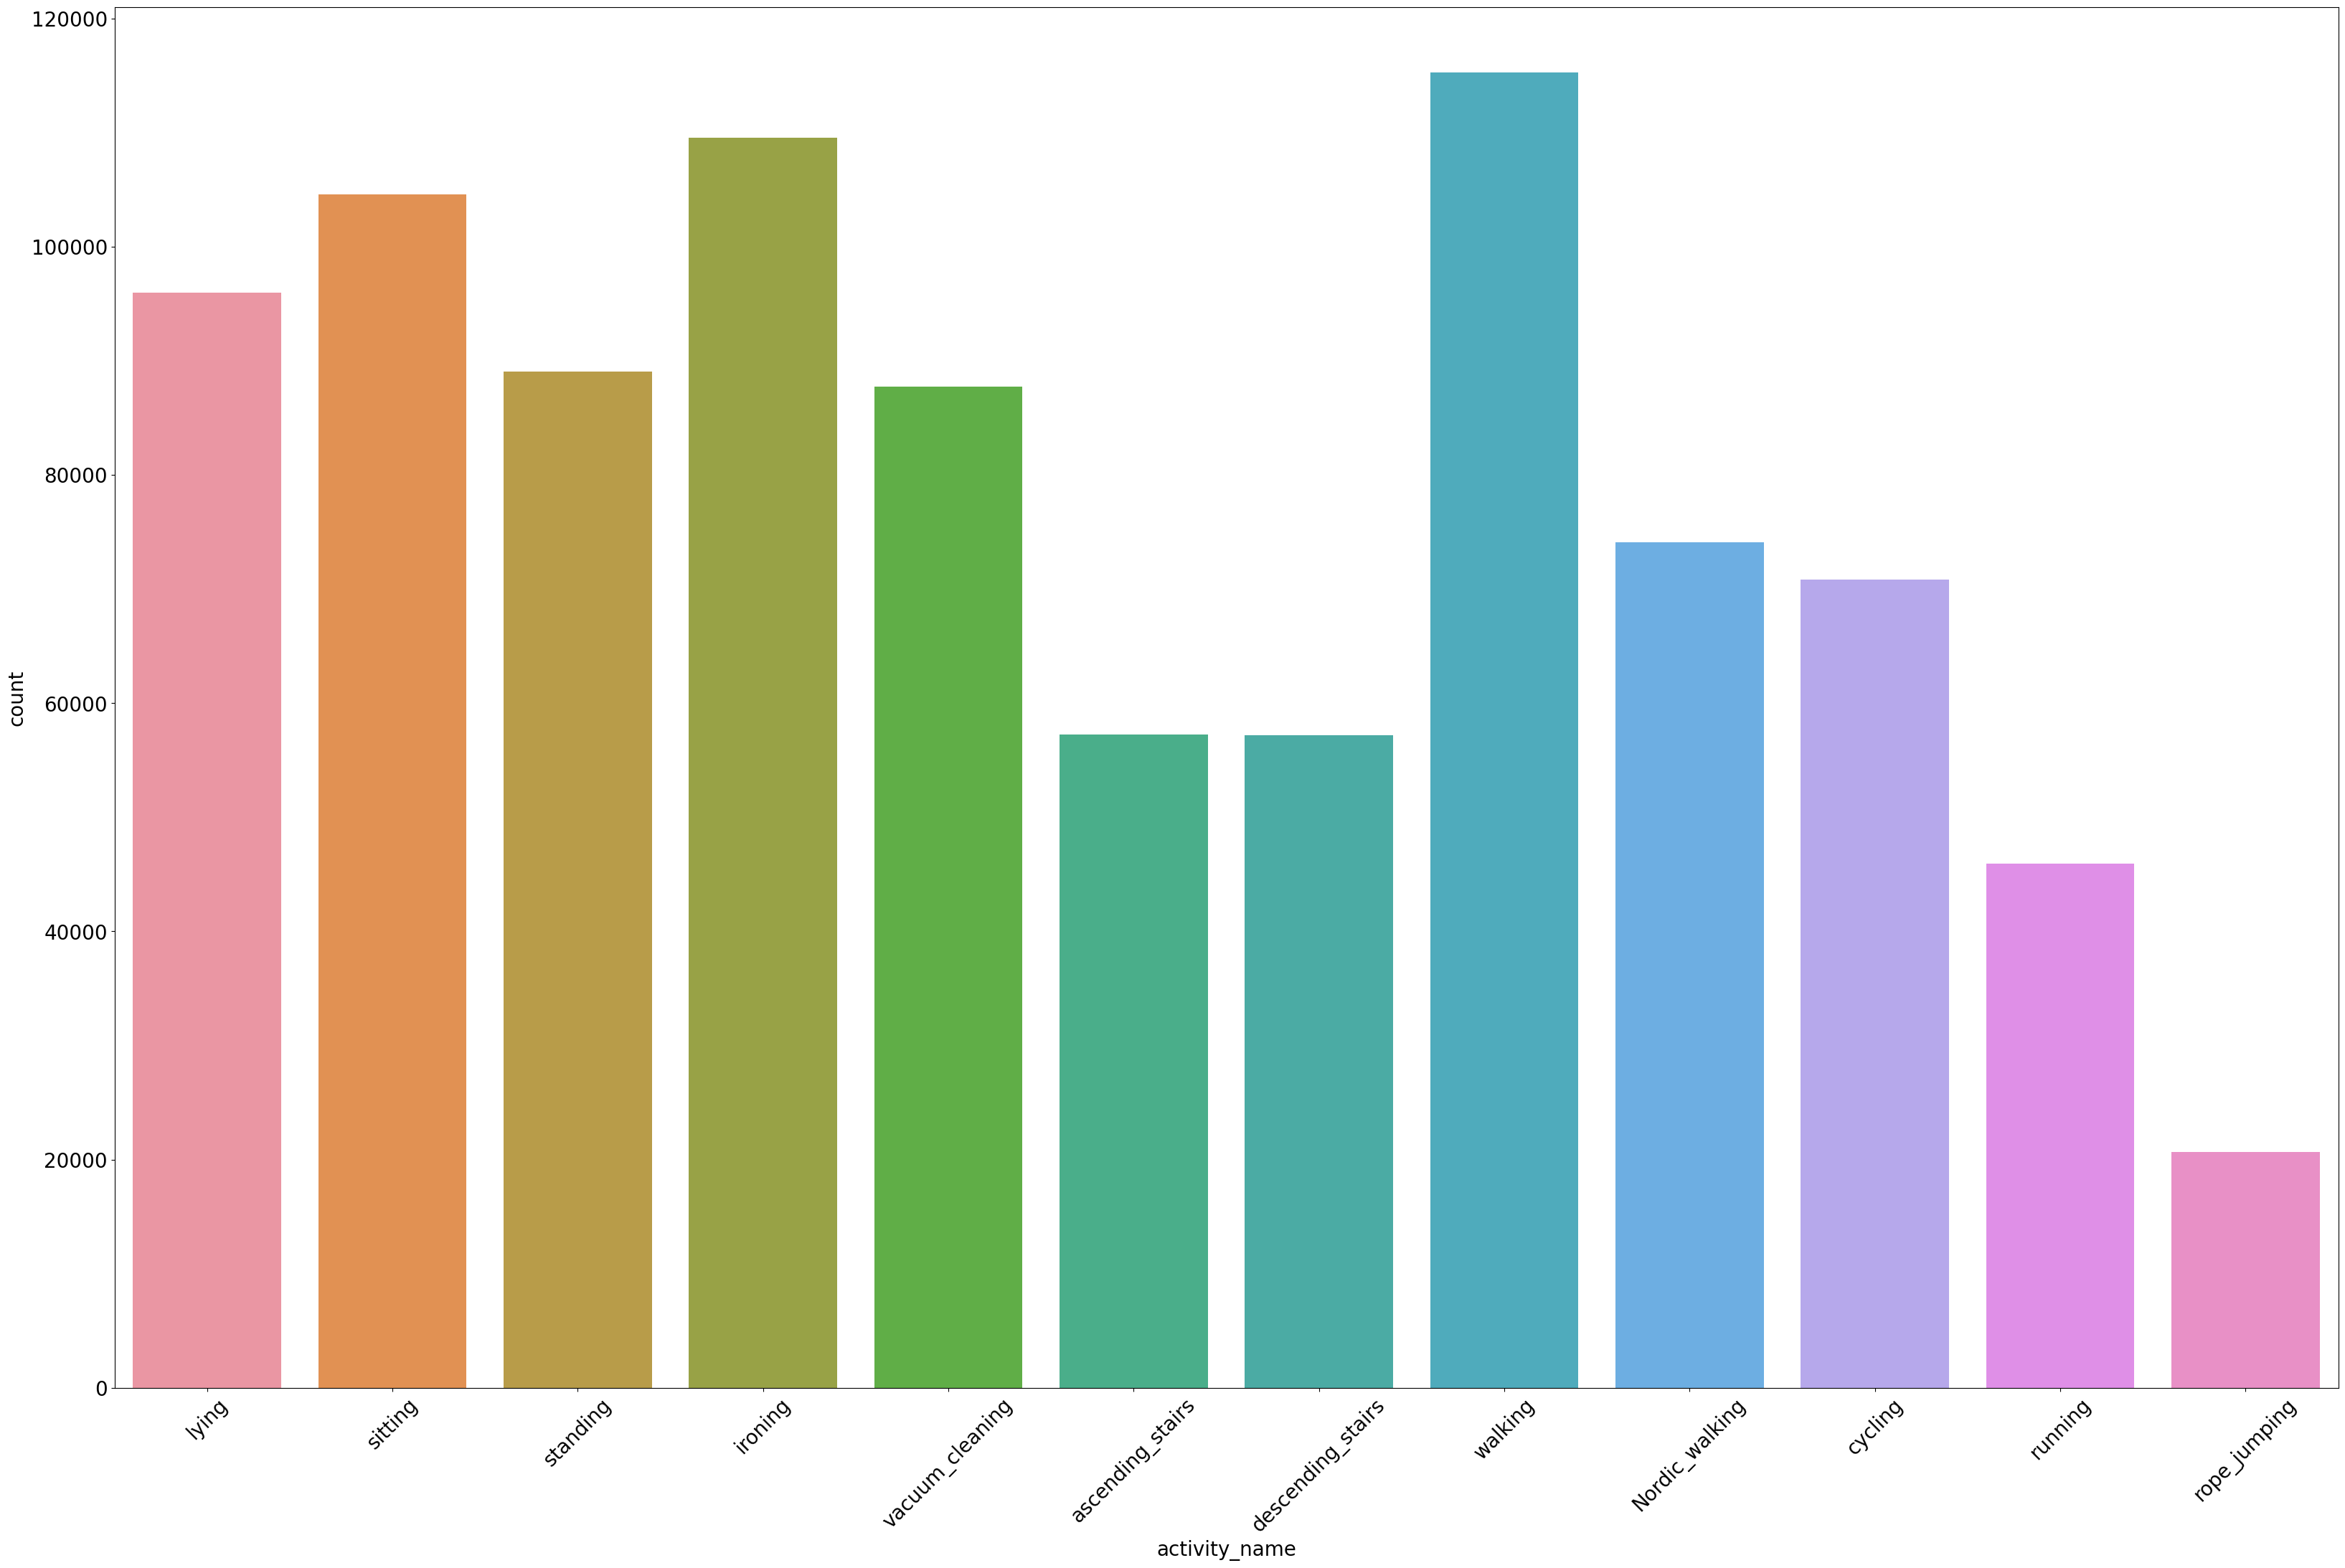

In [680]:
rcParams['figure.figsize'] = 40,25
ax=sns.countplot(x="activity_name",data=train)
ax.set_xticklabels(ax.get_xticklabels(),rotation=45)# Rotating Text
plt.show()

* 3D scatter plot of chest acceleration coordinates for lying<br>
<br>
  It is expected that vertical chest acceleration will be more while lying due to the<br>
  movements involved and an attempt is made to check this visually over here.

<Figure size 4000x2500 with 0 Axes>

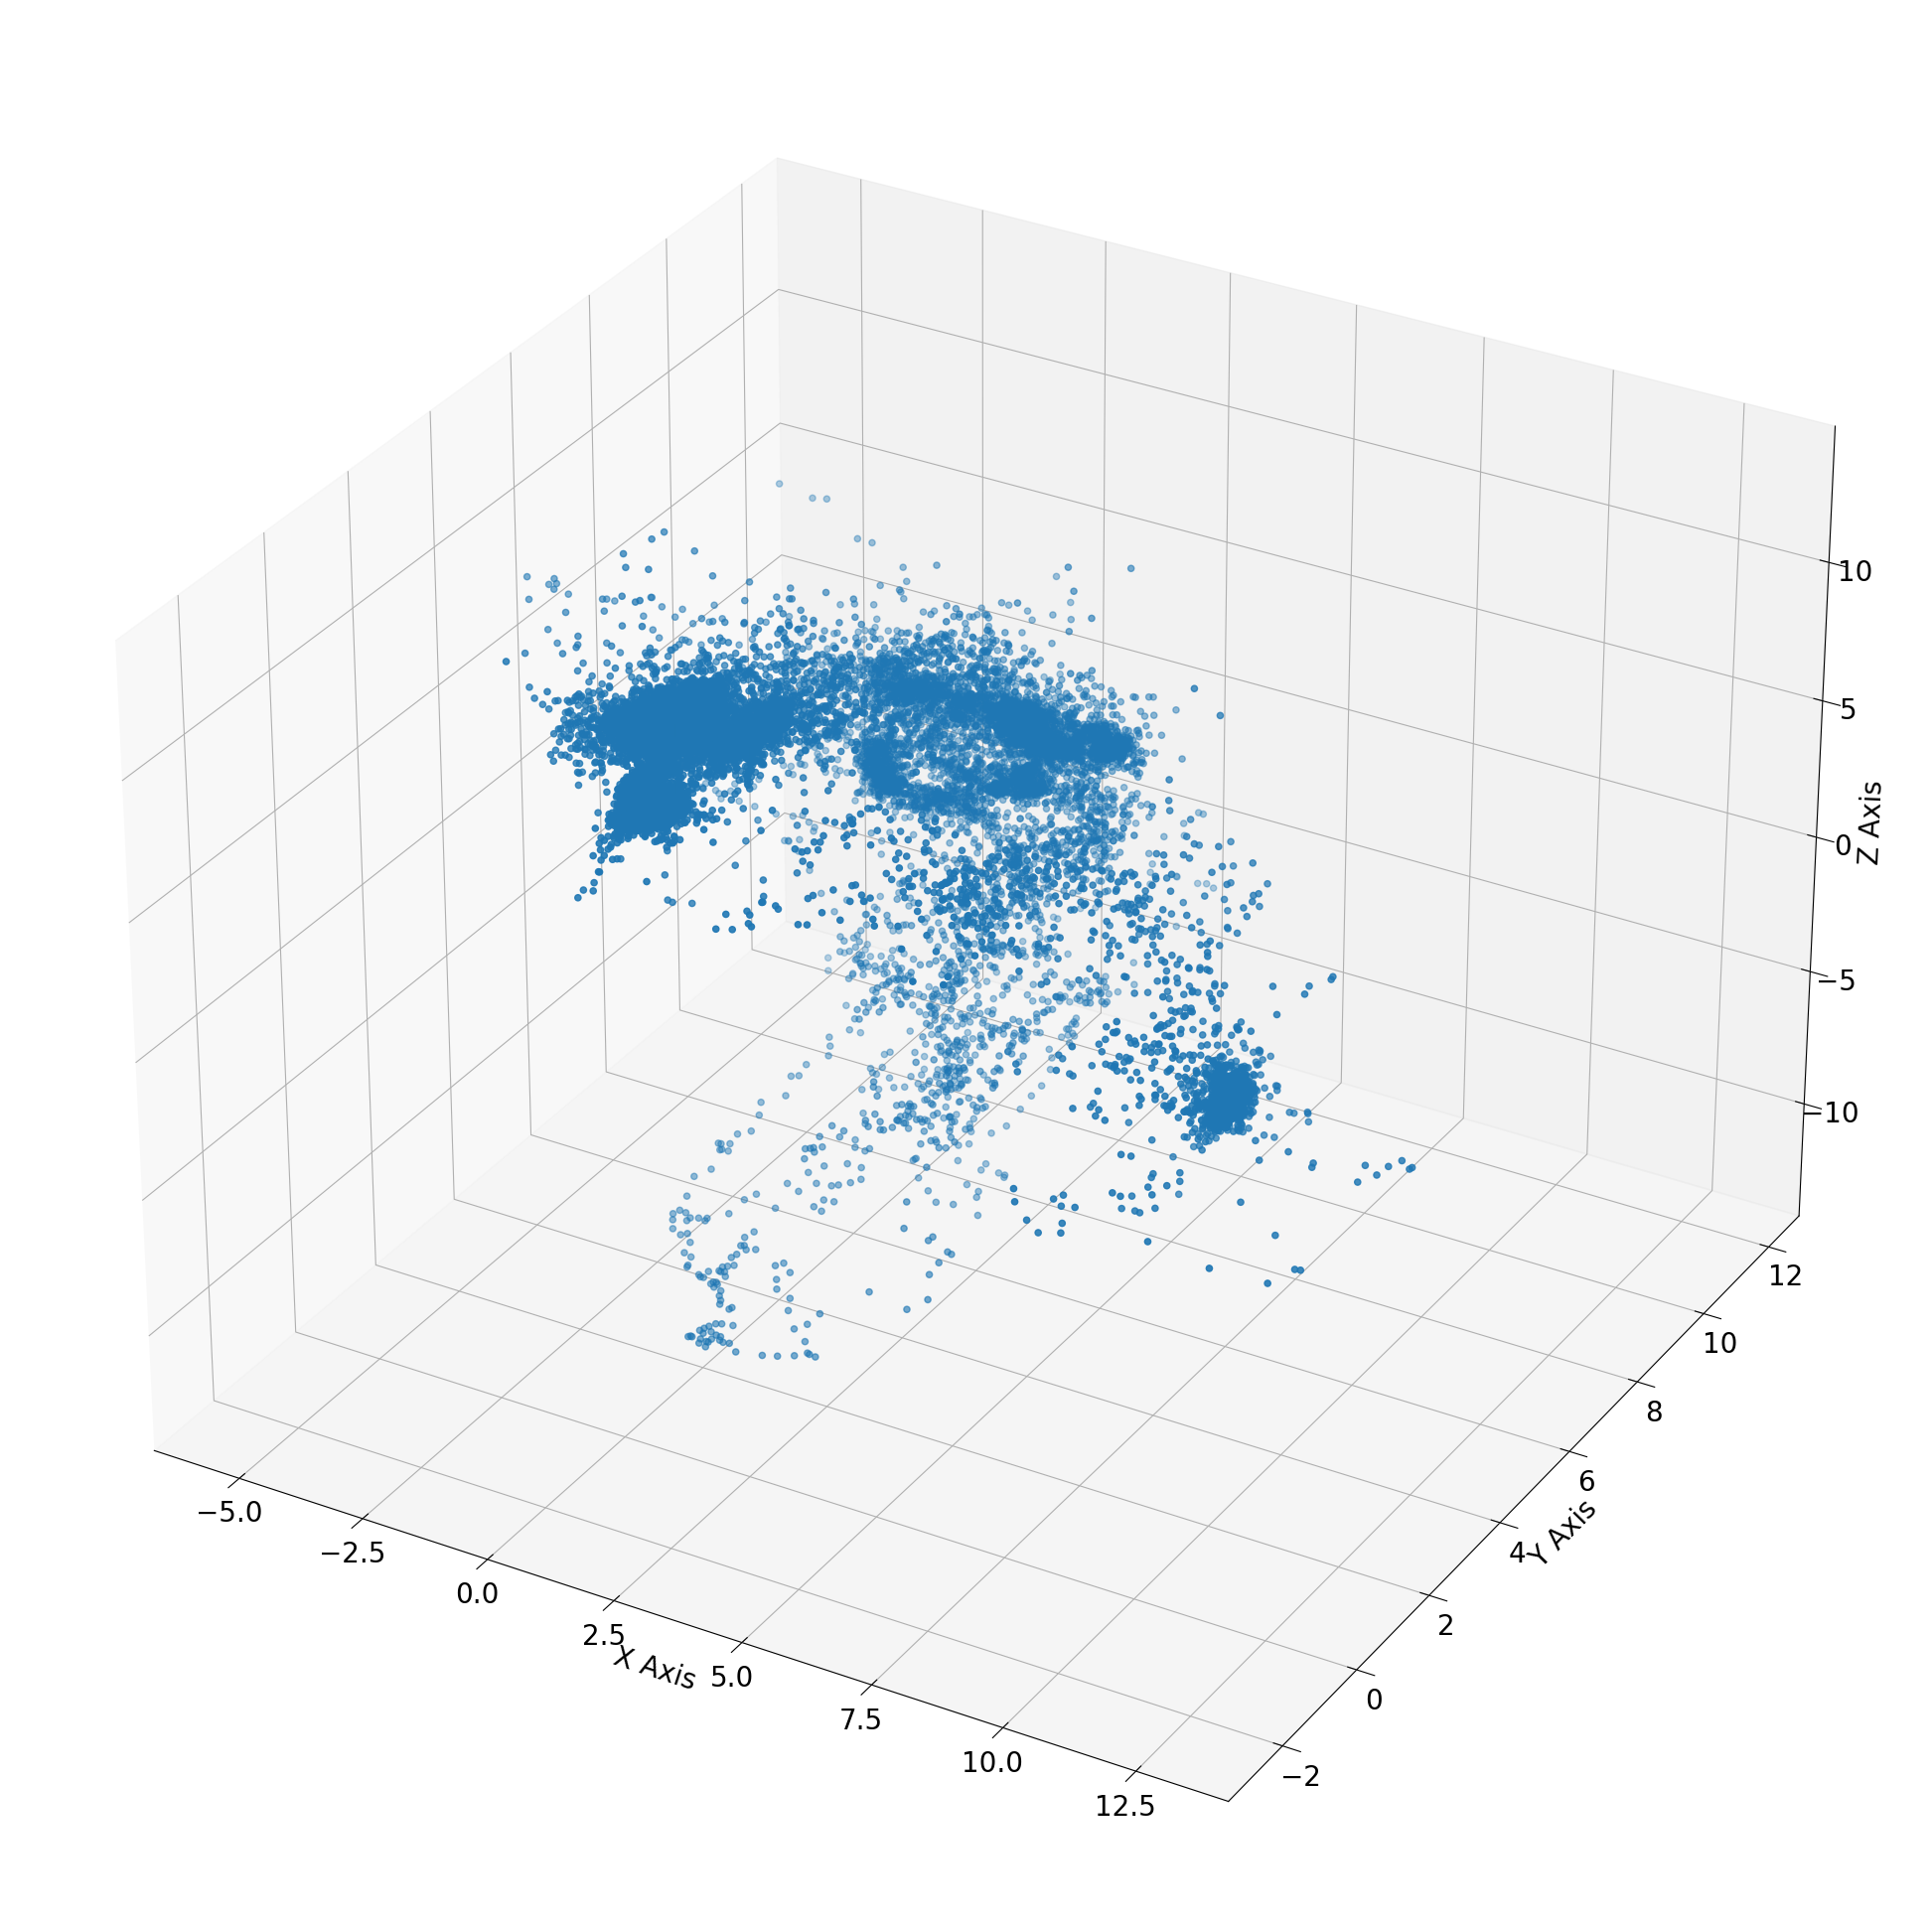

In [681]:
plt.clf()
train_running = train[train.activity_name=='lying']
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
x = train_running["chest_3D_acceleration_16_x"]
y = train_running["chest_3D_acceleration_16_y"]
z = train_running["chest_3D_acceleration_16_z"]
ax.scatter(x,y,z)
ax.set_xlabel('X Axis')
ax.set_ylabel('Y Axis')
ax.set_zlabel('Z Axis')
plt.show()

   As we see, there seems to be more variance along the z axis(vertical direction) than the<br>
   x and y axis.

* 3D scatter plot of chest acceleration coordinates for running<br>
<br>
  Since running involves mostly horizontal movements for the chest, we expect<br>
  most of chest acceleration data to lie on the horizontal x amd y axis.

<Figure size 4000x2500 with 0 Axes>

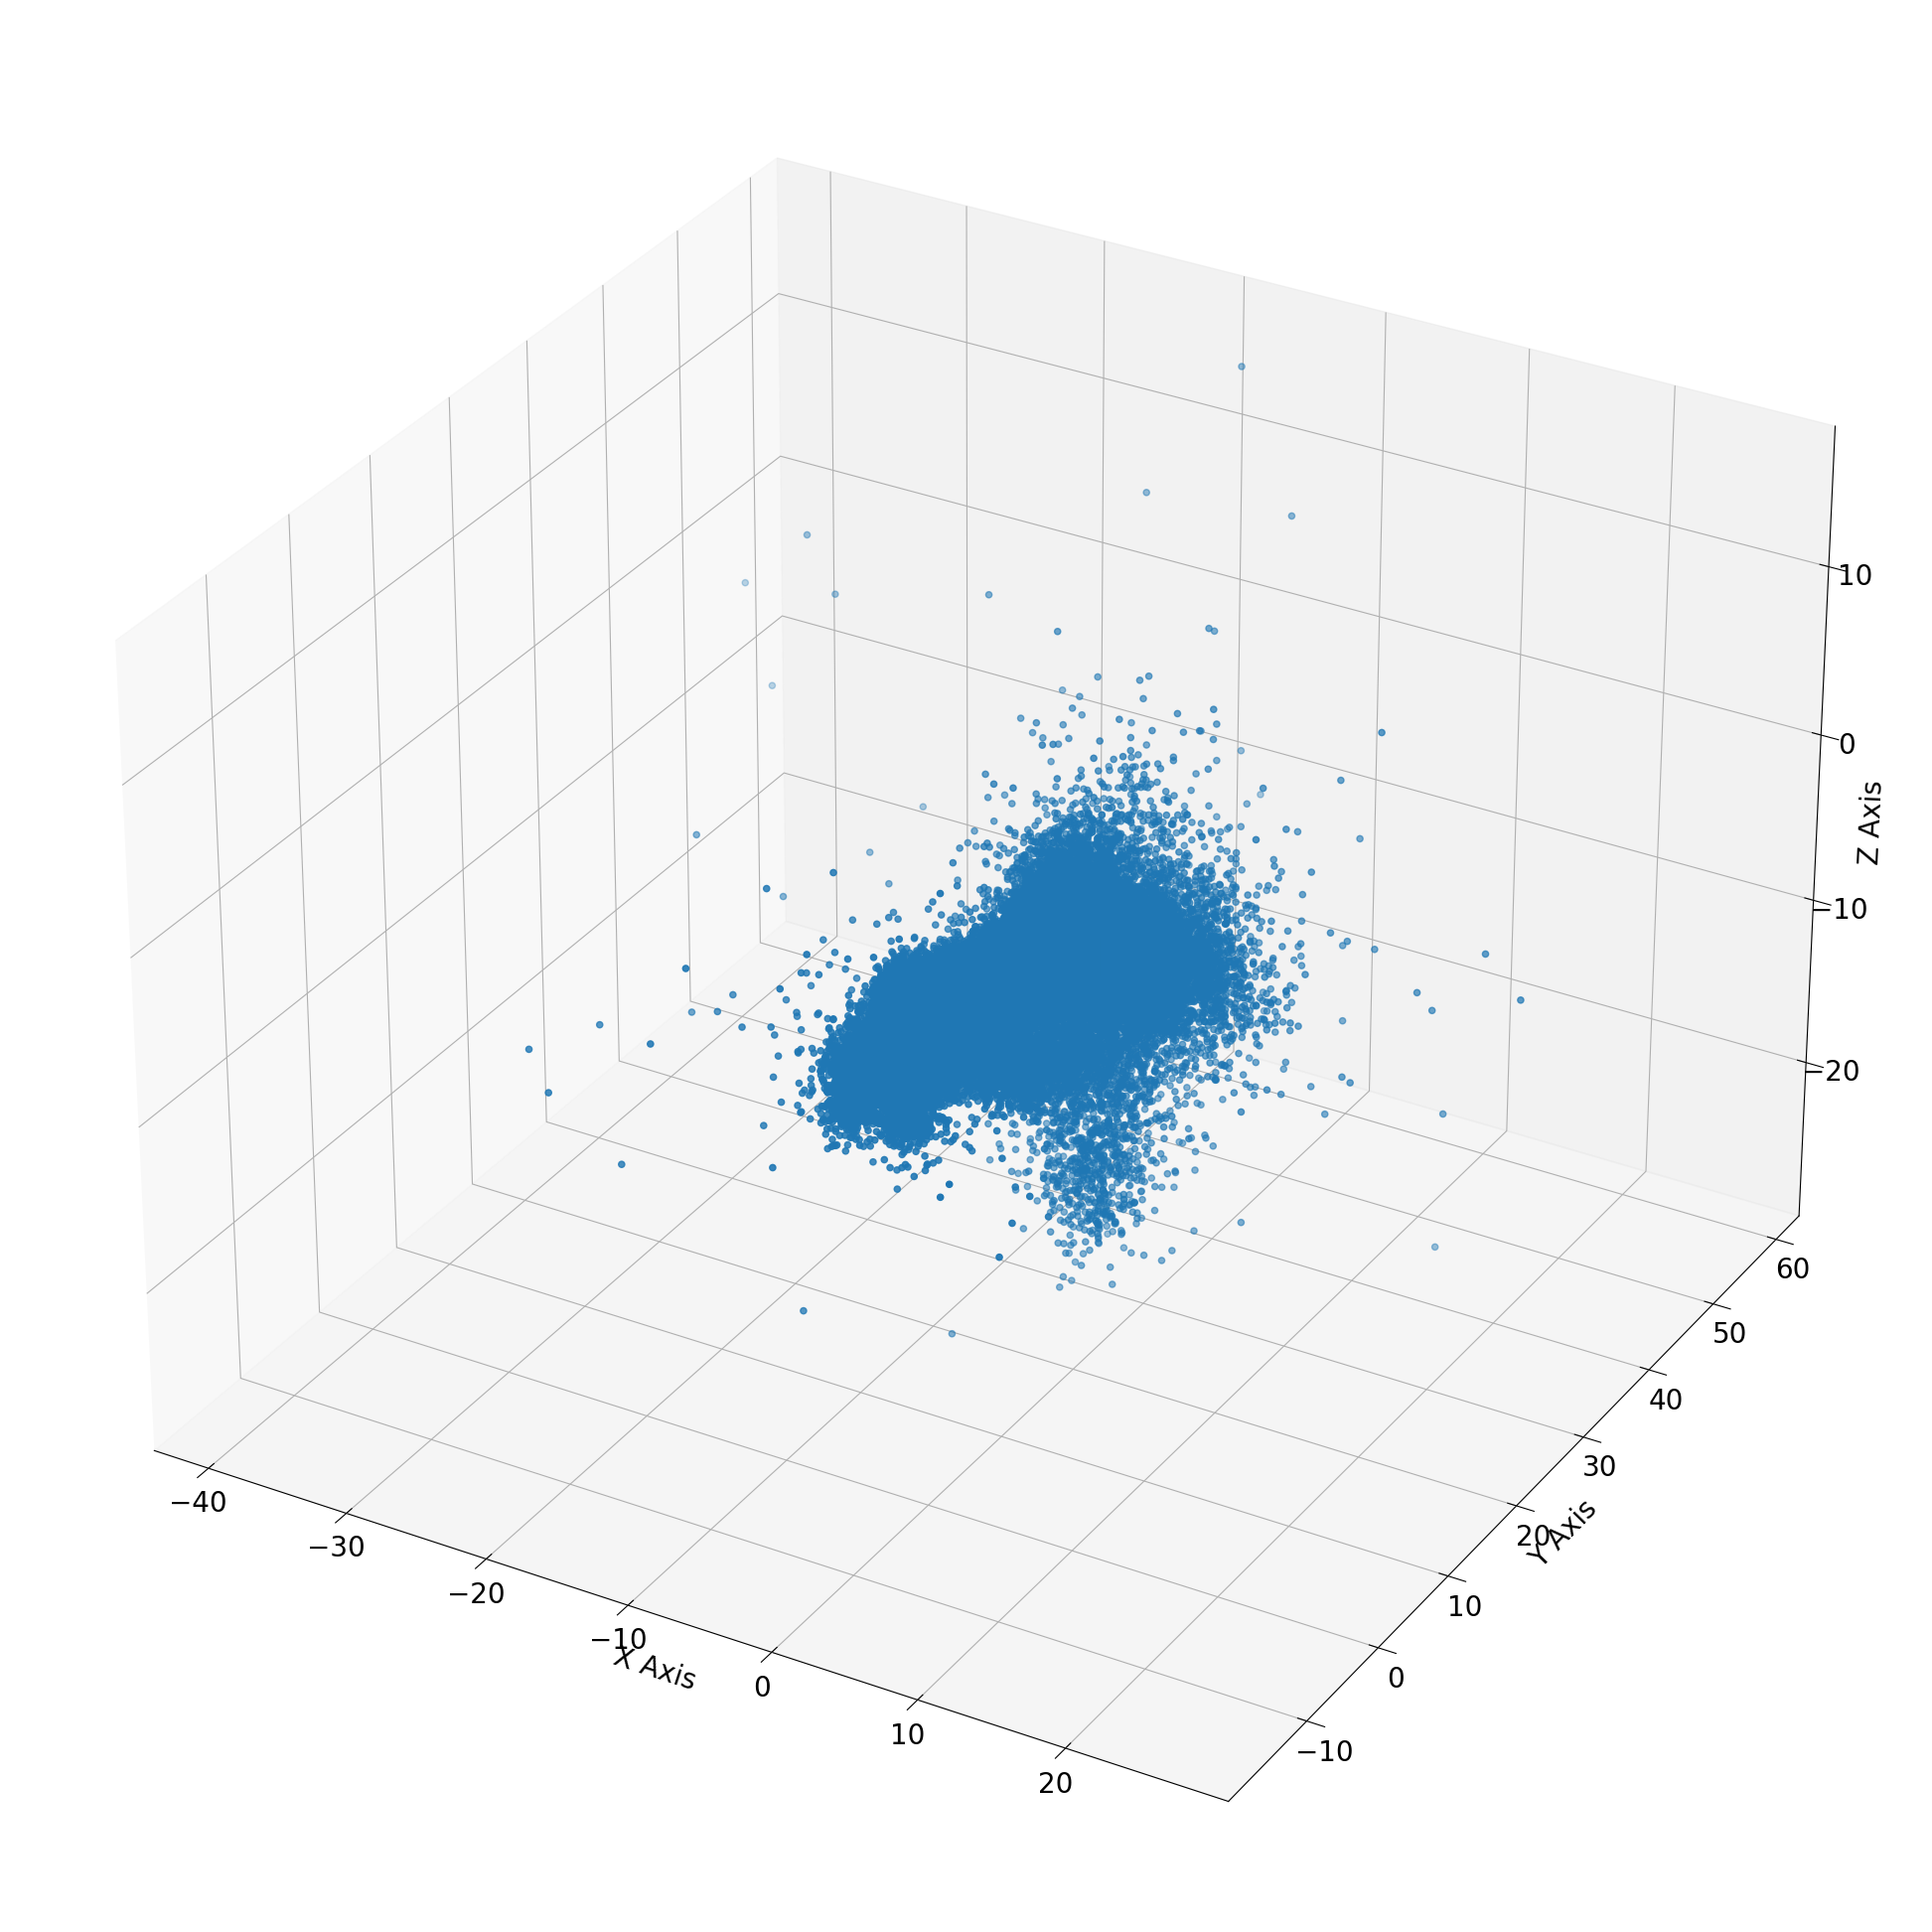

In [682]:
plt.clf()
train_running = train[train.activity_name=='running']
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
x = train_running["chest_3D_acceleration_16_x"]
y = train_running["chest_3D_acceleration_16_y"]
z = train_running["chest_3D_acceleration_16_z"]
ax.scatter(x,y,z)
ax.set_xlabel('X Axis')
ax.set_ylabel('Y Axis')
ax.set_zlabel('Z Axis')
plt.show()

  As we expected, for running, most of the points lie along the x and y axis.

* Time series plot of x axis chest acceleration

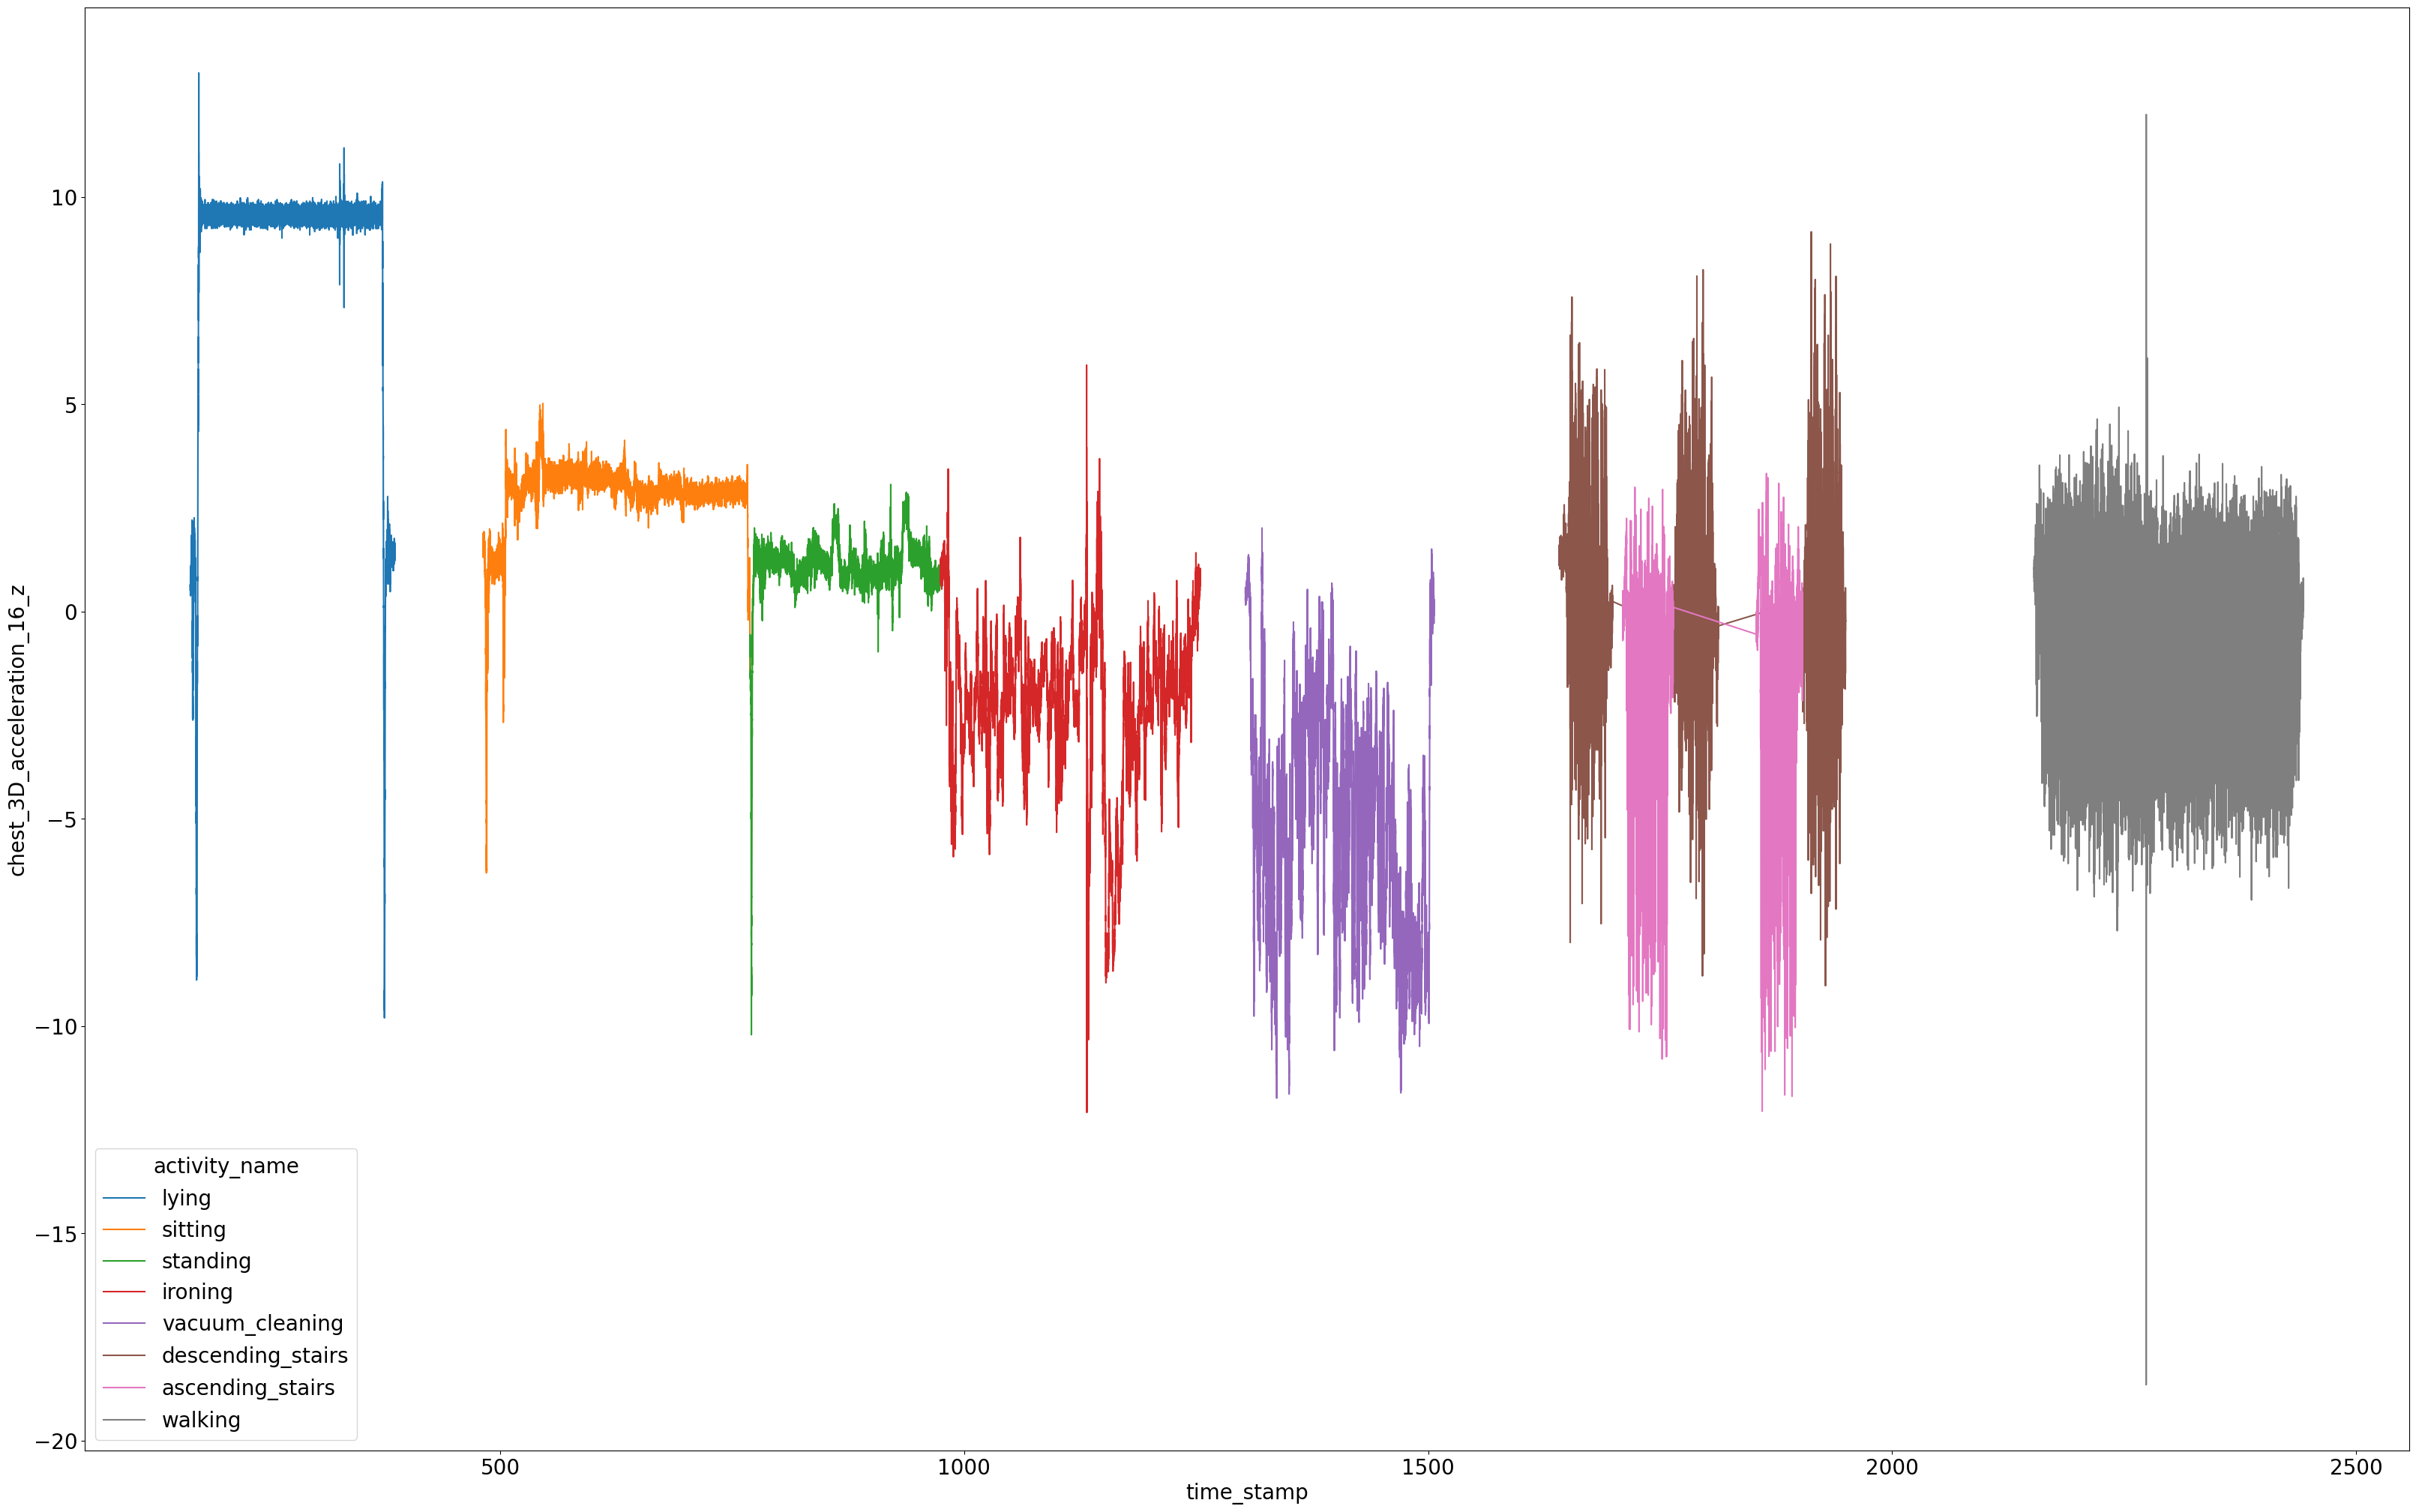

In [683]:
plt.clf()
random.seed(4)
train1 = train[train.id==random.choice(train.id.unique())]
sns.lineplot(x='time_stamp',y='chest_3D_acceleration_16_z',hue='activity_name',data=train1)
plt.show()

* Boxplot of rolling mean of vertical chest acceleration

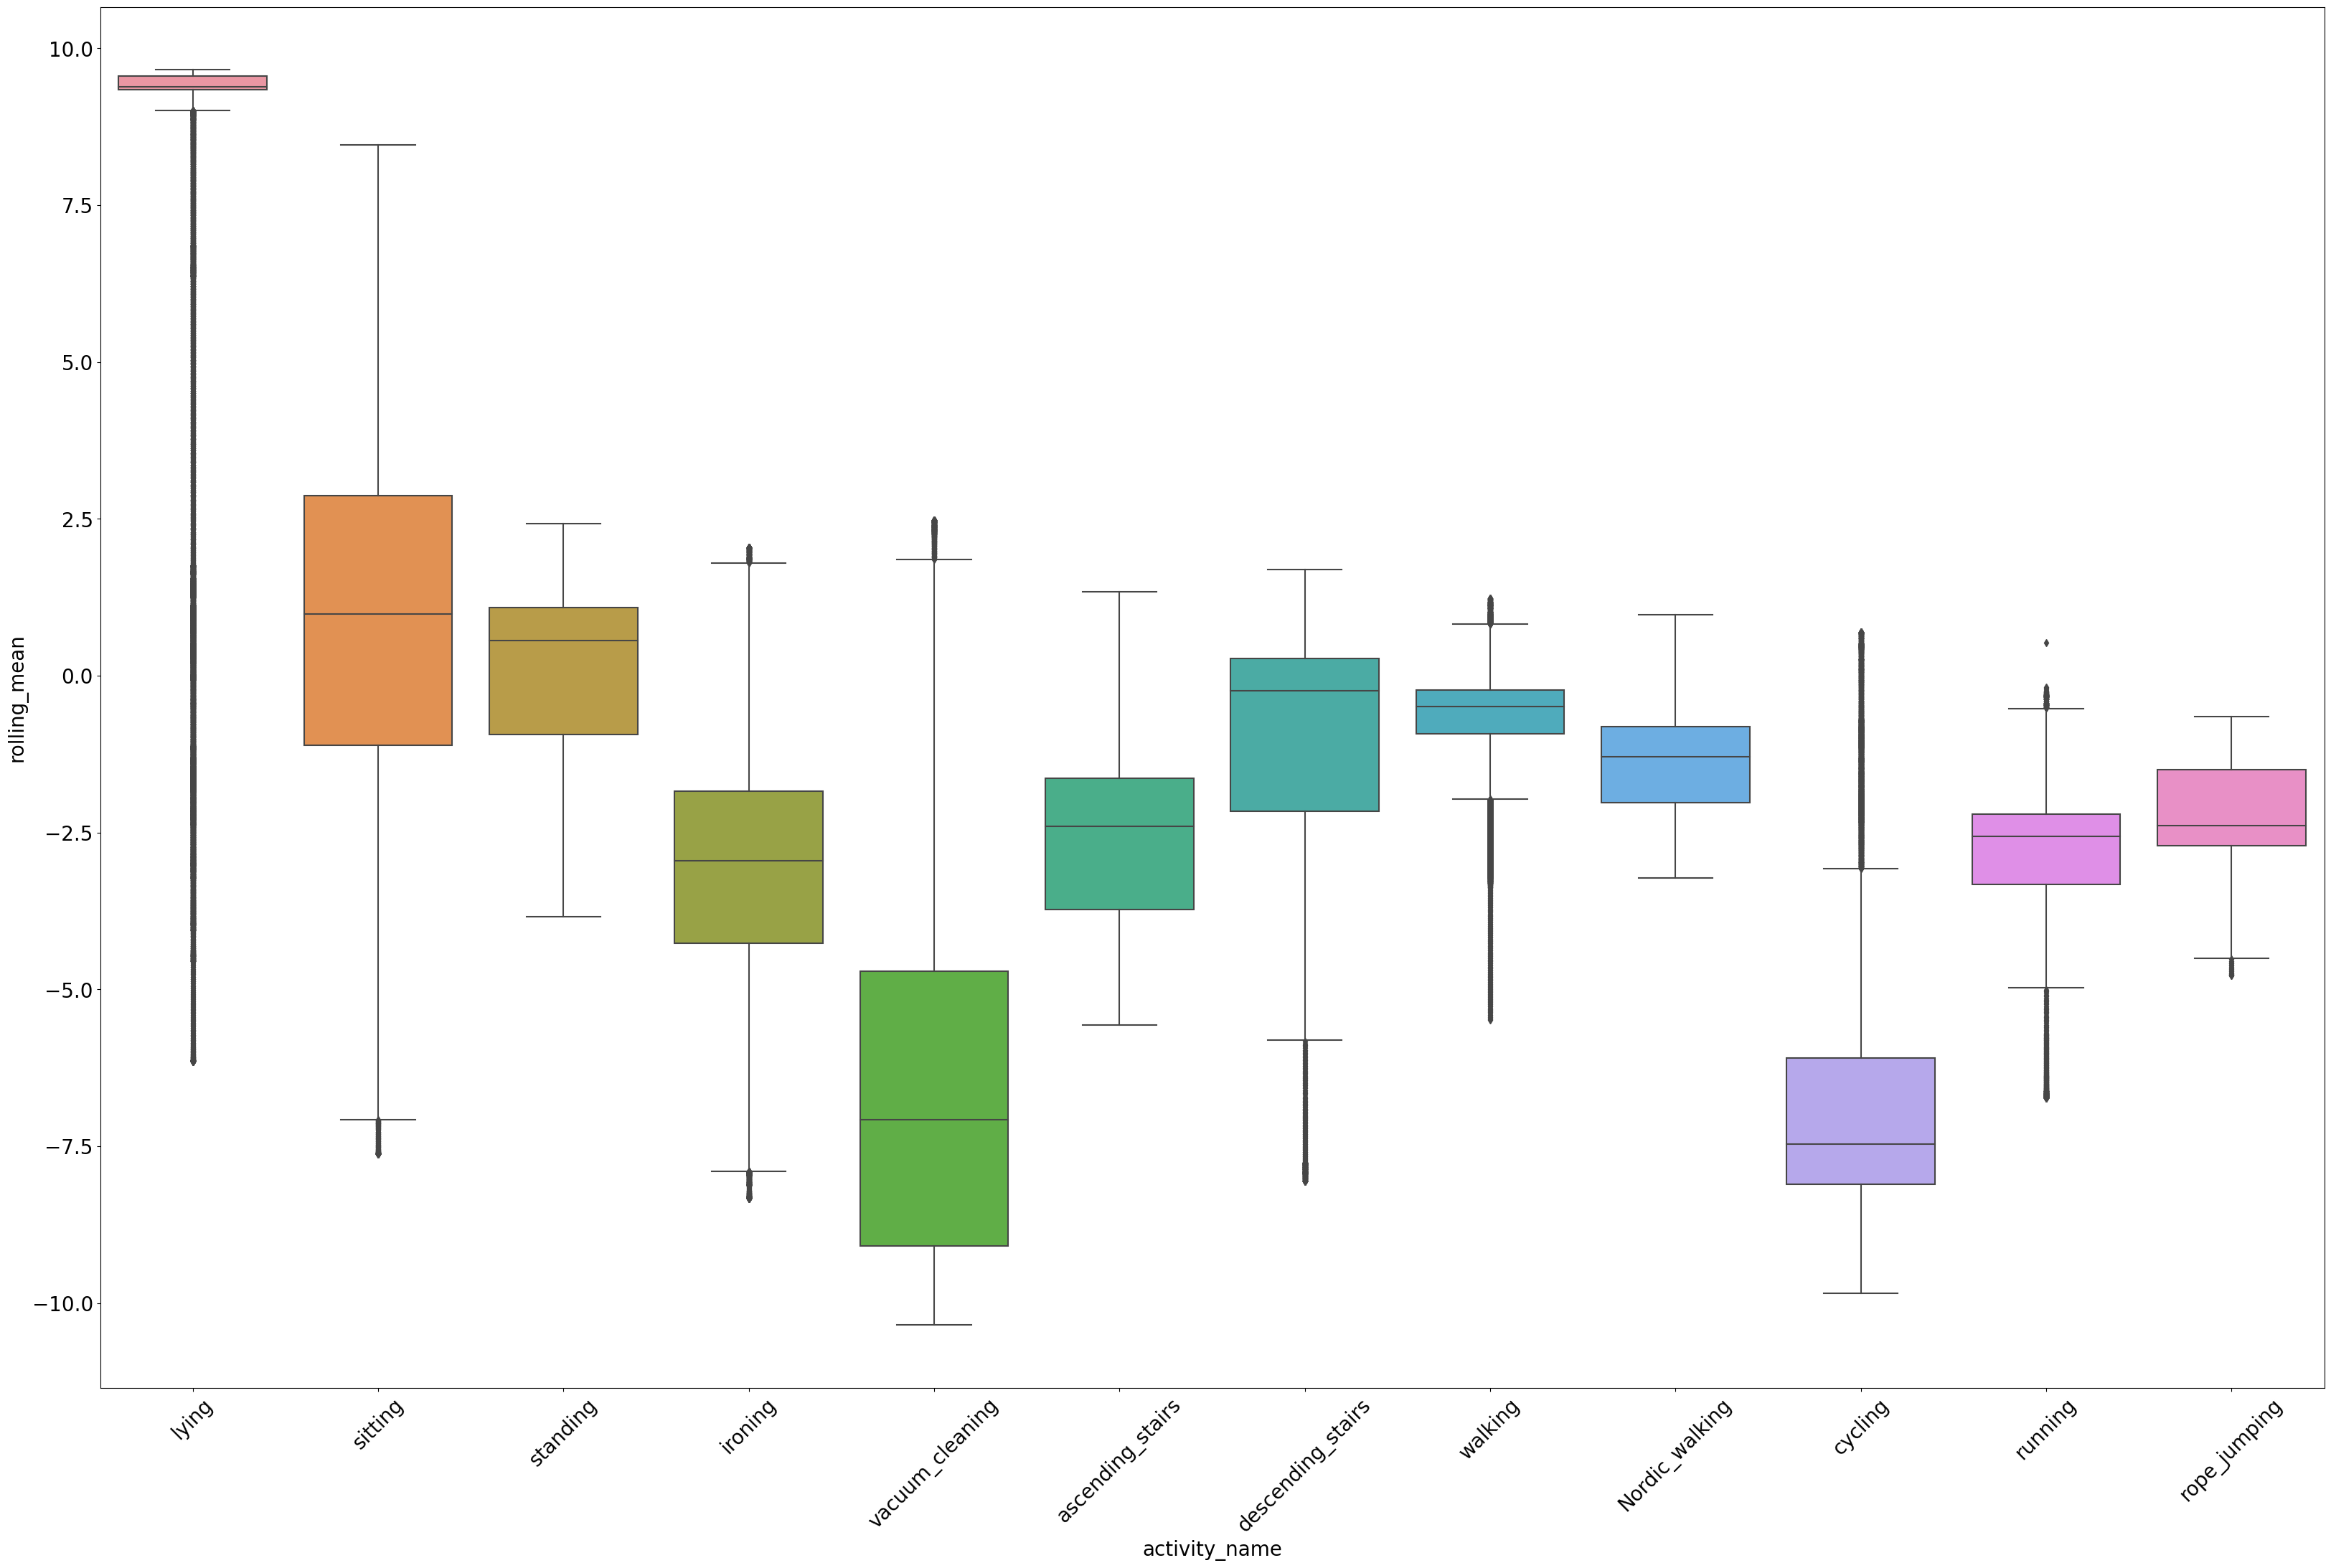

In [684]:
train['rolling_mean'] = train['chest_3D_acceleration_16_z'].rolling(256).mean()
ax=sns.boxplot(x="activity_name",y="rolling_mean",data=train)
ax.set_xticklabels(ax.get_xticklabels(),rotation=45)# Rotating Text
plt.show()

* Boxplot of rolling mean of horizontal ankle acceleration along x axis

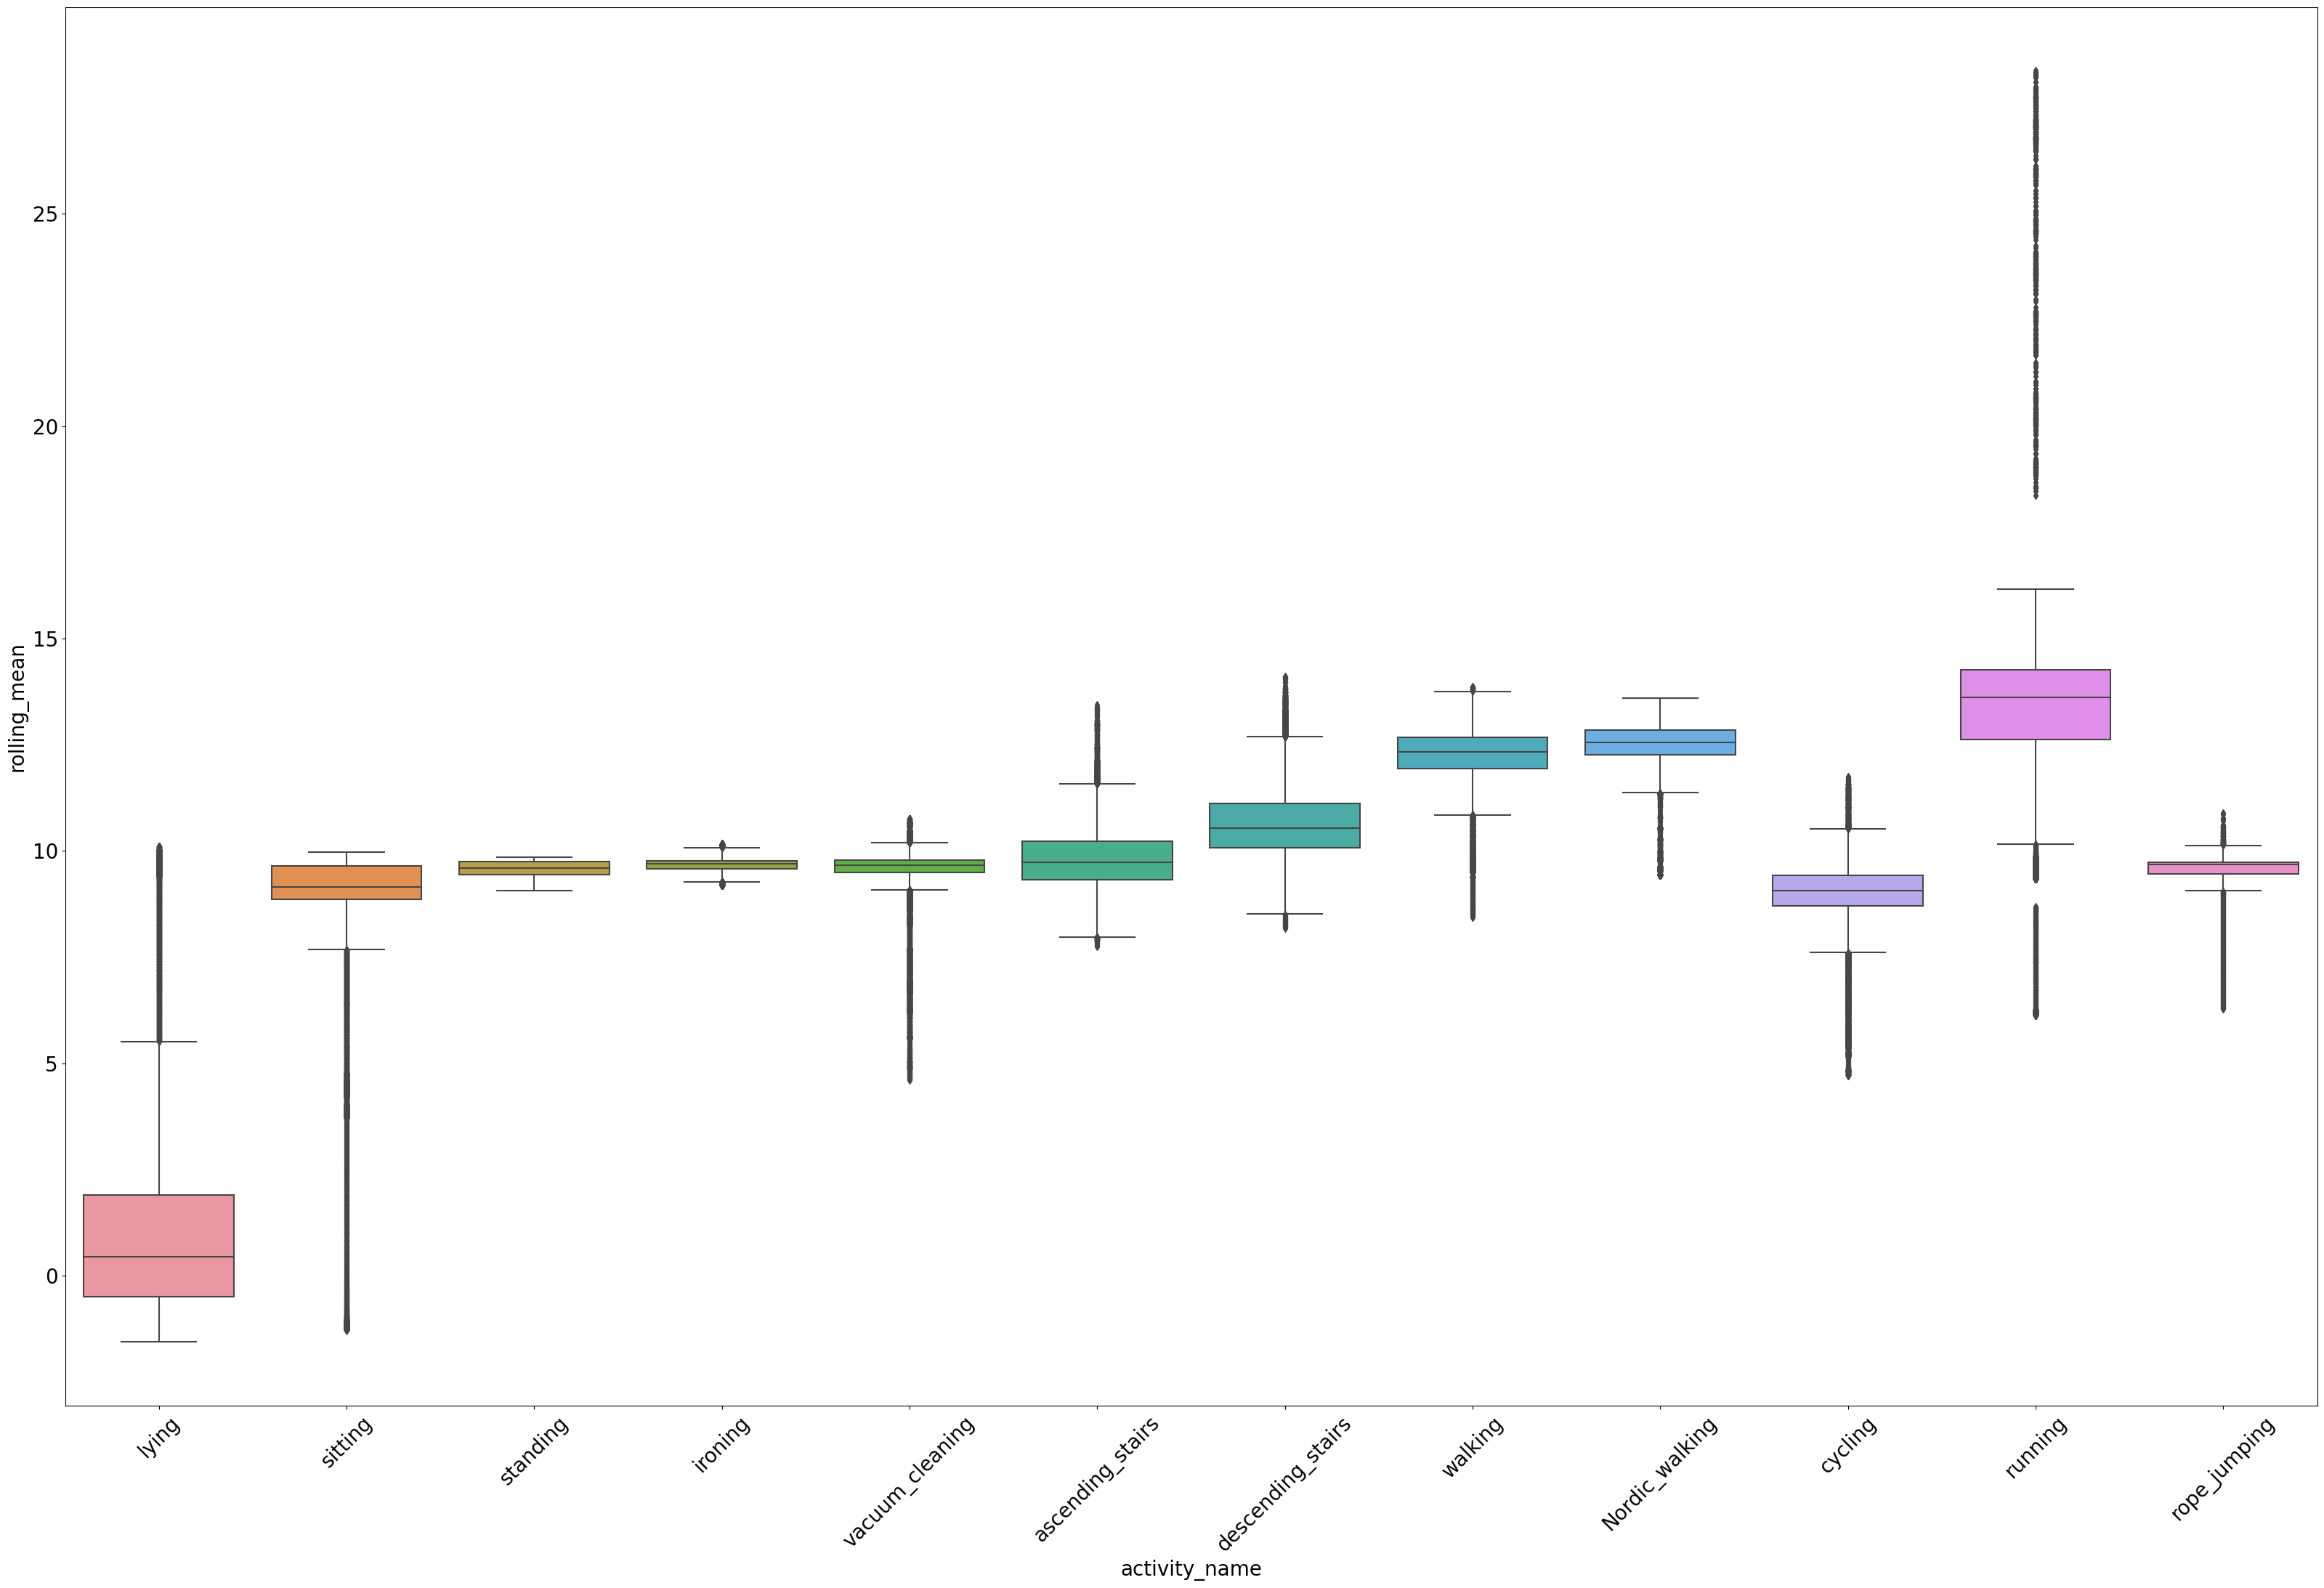

In [685]:
train['rolling_mean'] = train['ankle_3D_acceleration_16_x'].rolling(256).mean()
ax=sns.boxplot(x="activity_name",y="rolling_mean",data=train)
ax.set_xticklabels(ax.get_xticklabels(),rotation=45)# Rotating Text
plt.show()

* Boxplot of rolling mean of horizontal ankle acceleration along y axis 

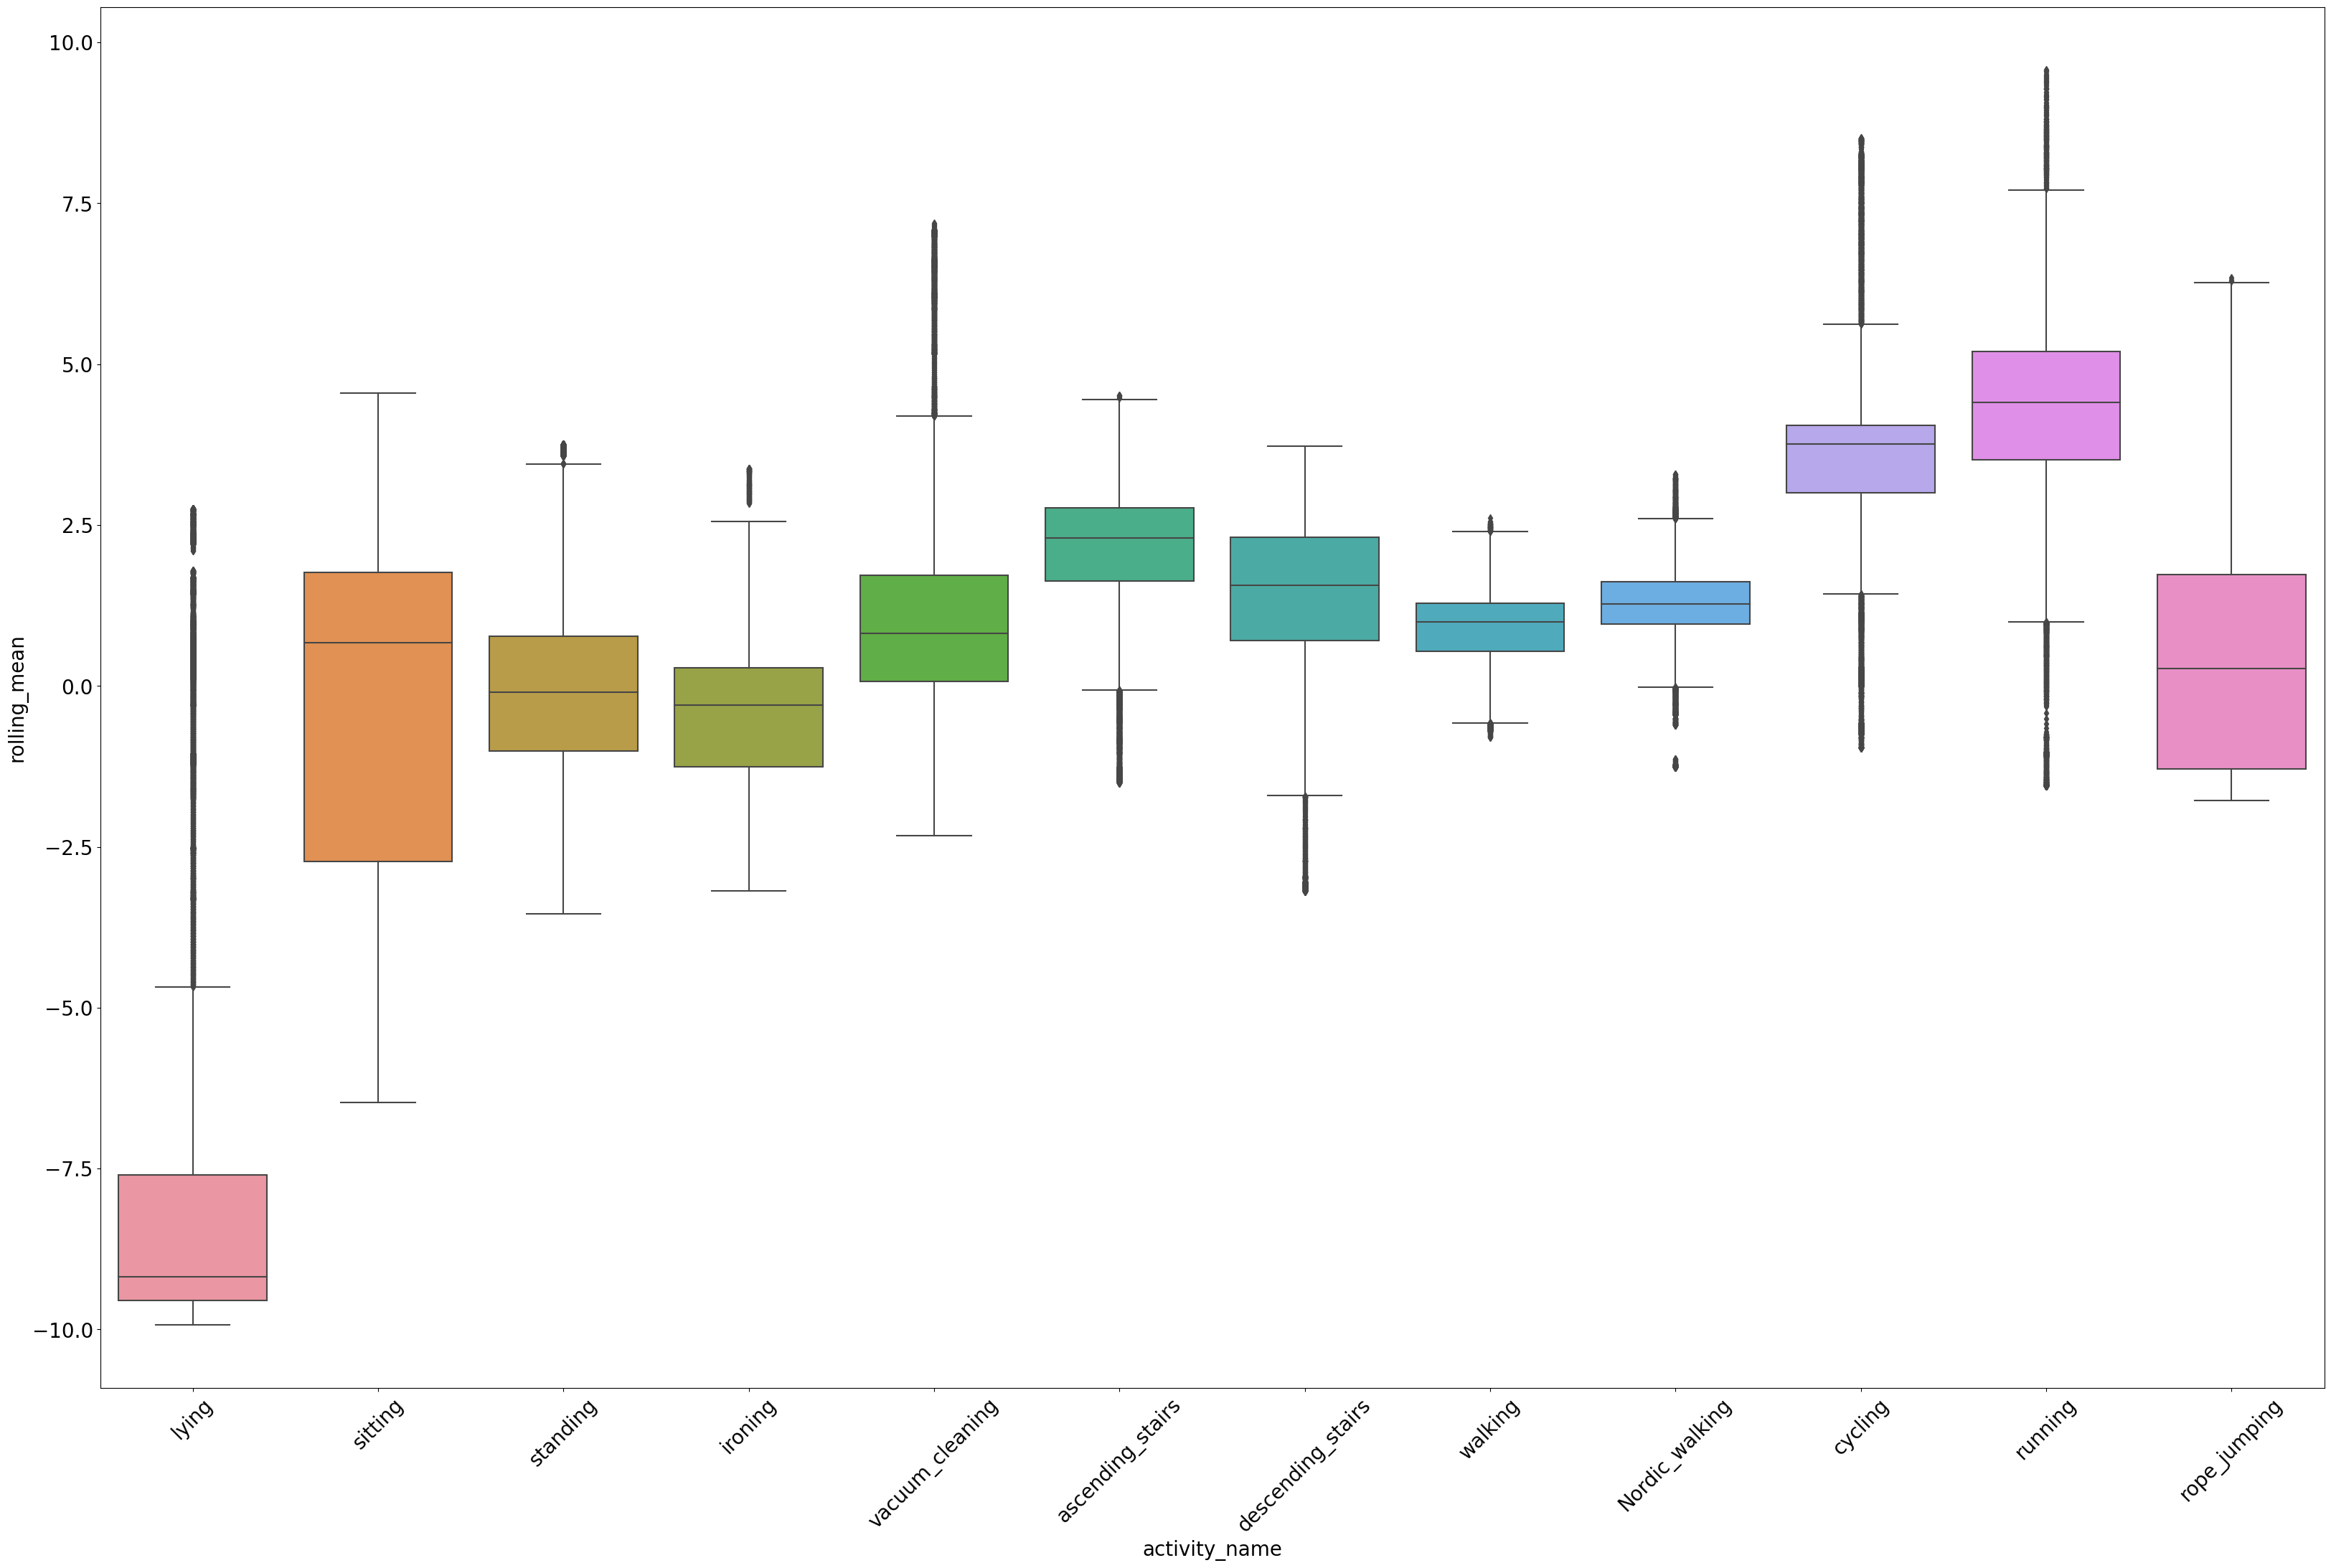

In [686]:
train['rolling_mean'] = train['ankle_3D_acceleration_16_y'].rolling(256).mean()
ax=sns.boxplot(x="activity_name",y="rolling_mean",data=train)
ax.set_xticklabels(ax.get_xticklabels(),rotation=45)# Rotating Text
plt.show()

* Boxplot of heart rate grouped by activity type. 

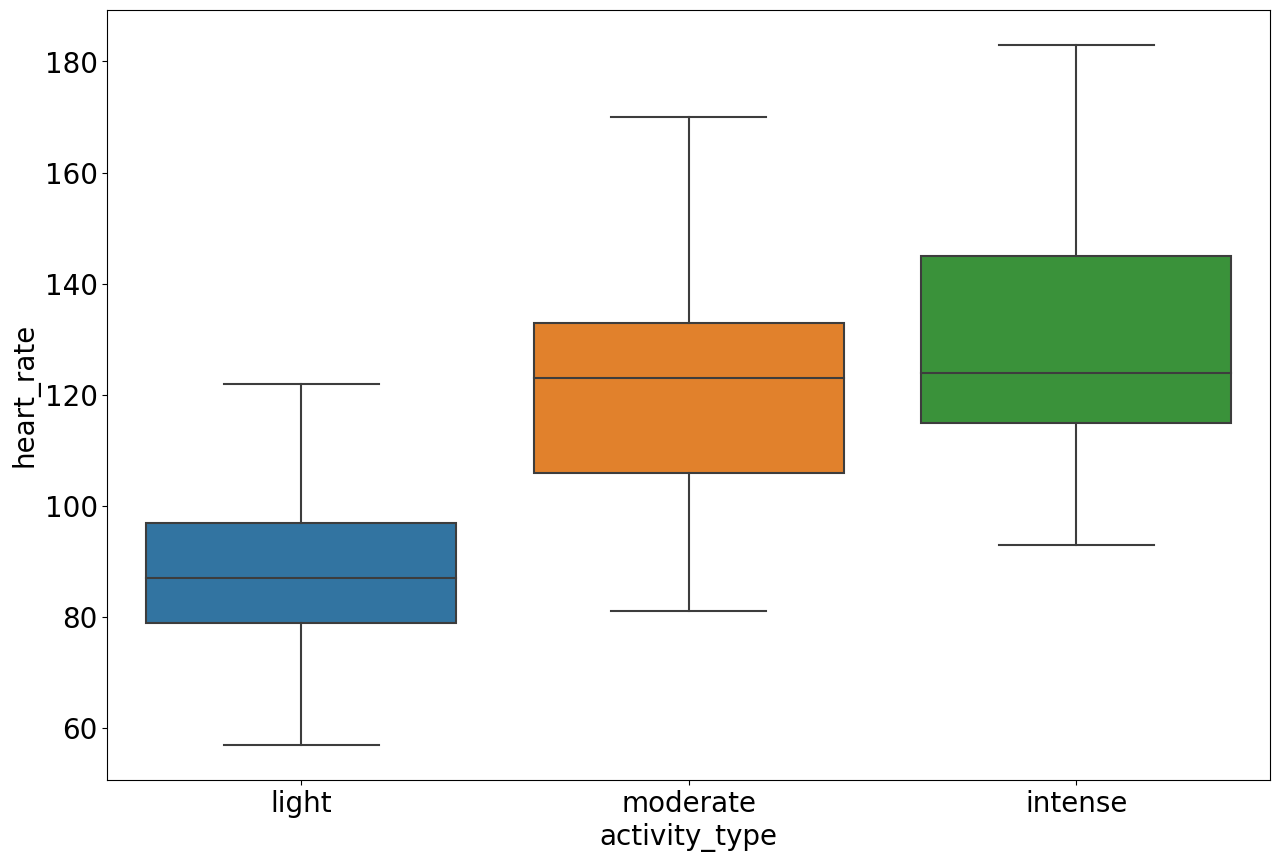

In [687]:
rcParams['figure.figsize'] = 15,10
ax=sns.boxplot(x="activity_type",y="heart_rate",data=train)
ax.set_xticklabels(ax.get_xticklabels(),rotation=0)# Rotating Text
plt.show()

 1. We observe that moderate and intense activities have higher heart rate than<br>
    light activities as expected.<br>
 2. There doesn't seem to be much seperation between moderate and intesne activity<br>
    heart rate.

* Boxplot of heart rate grouped by activity. 

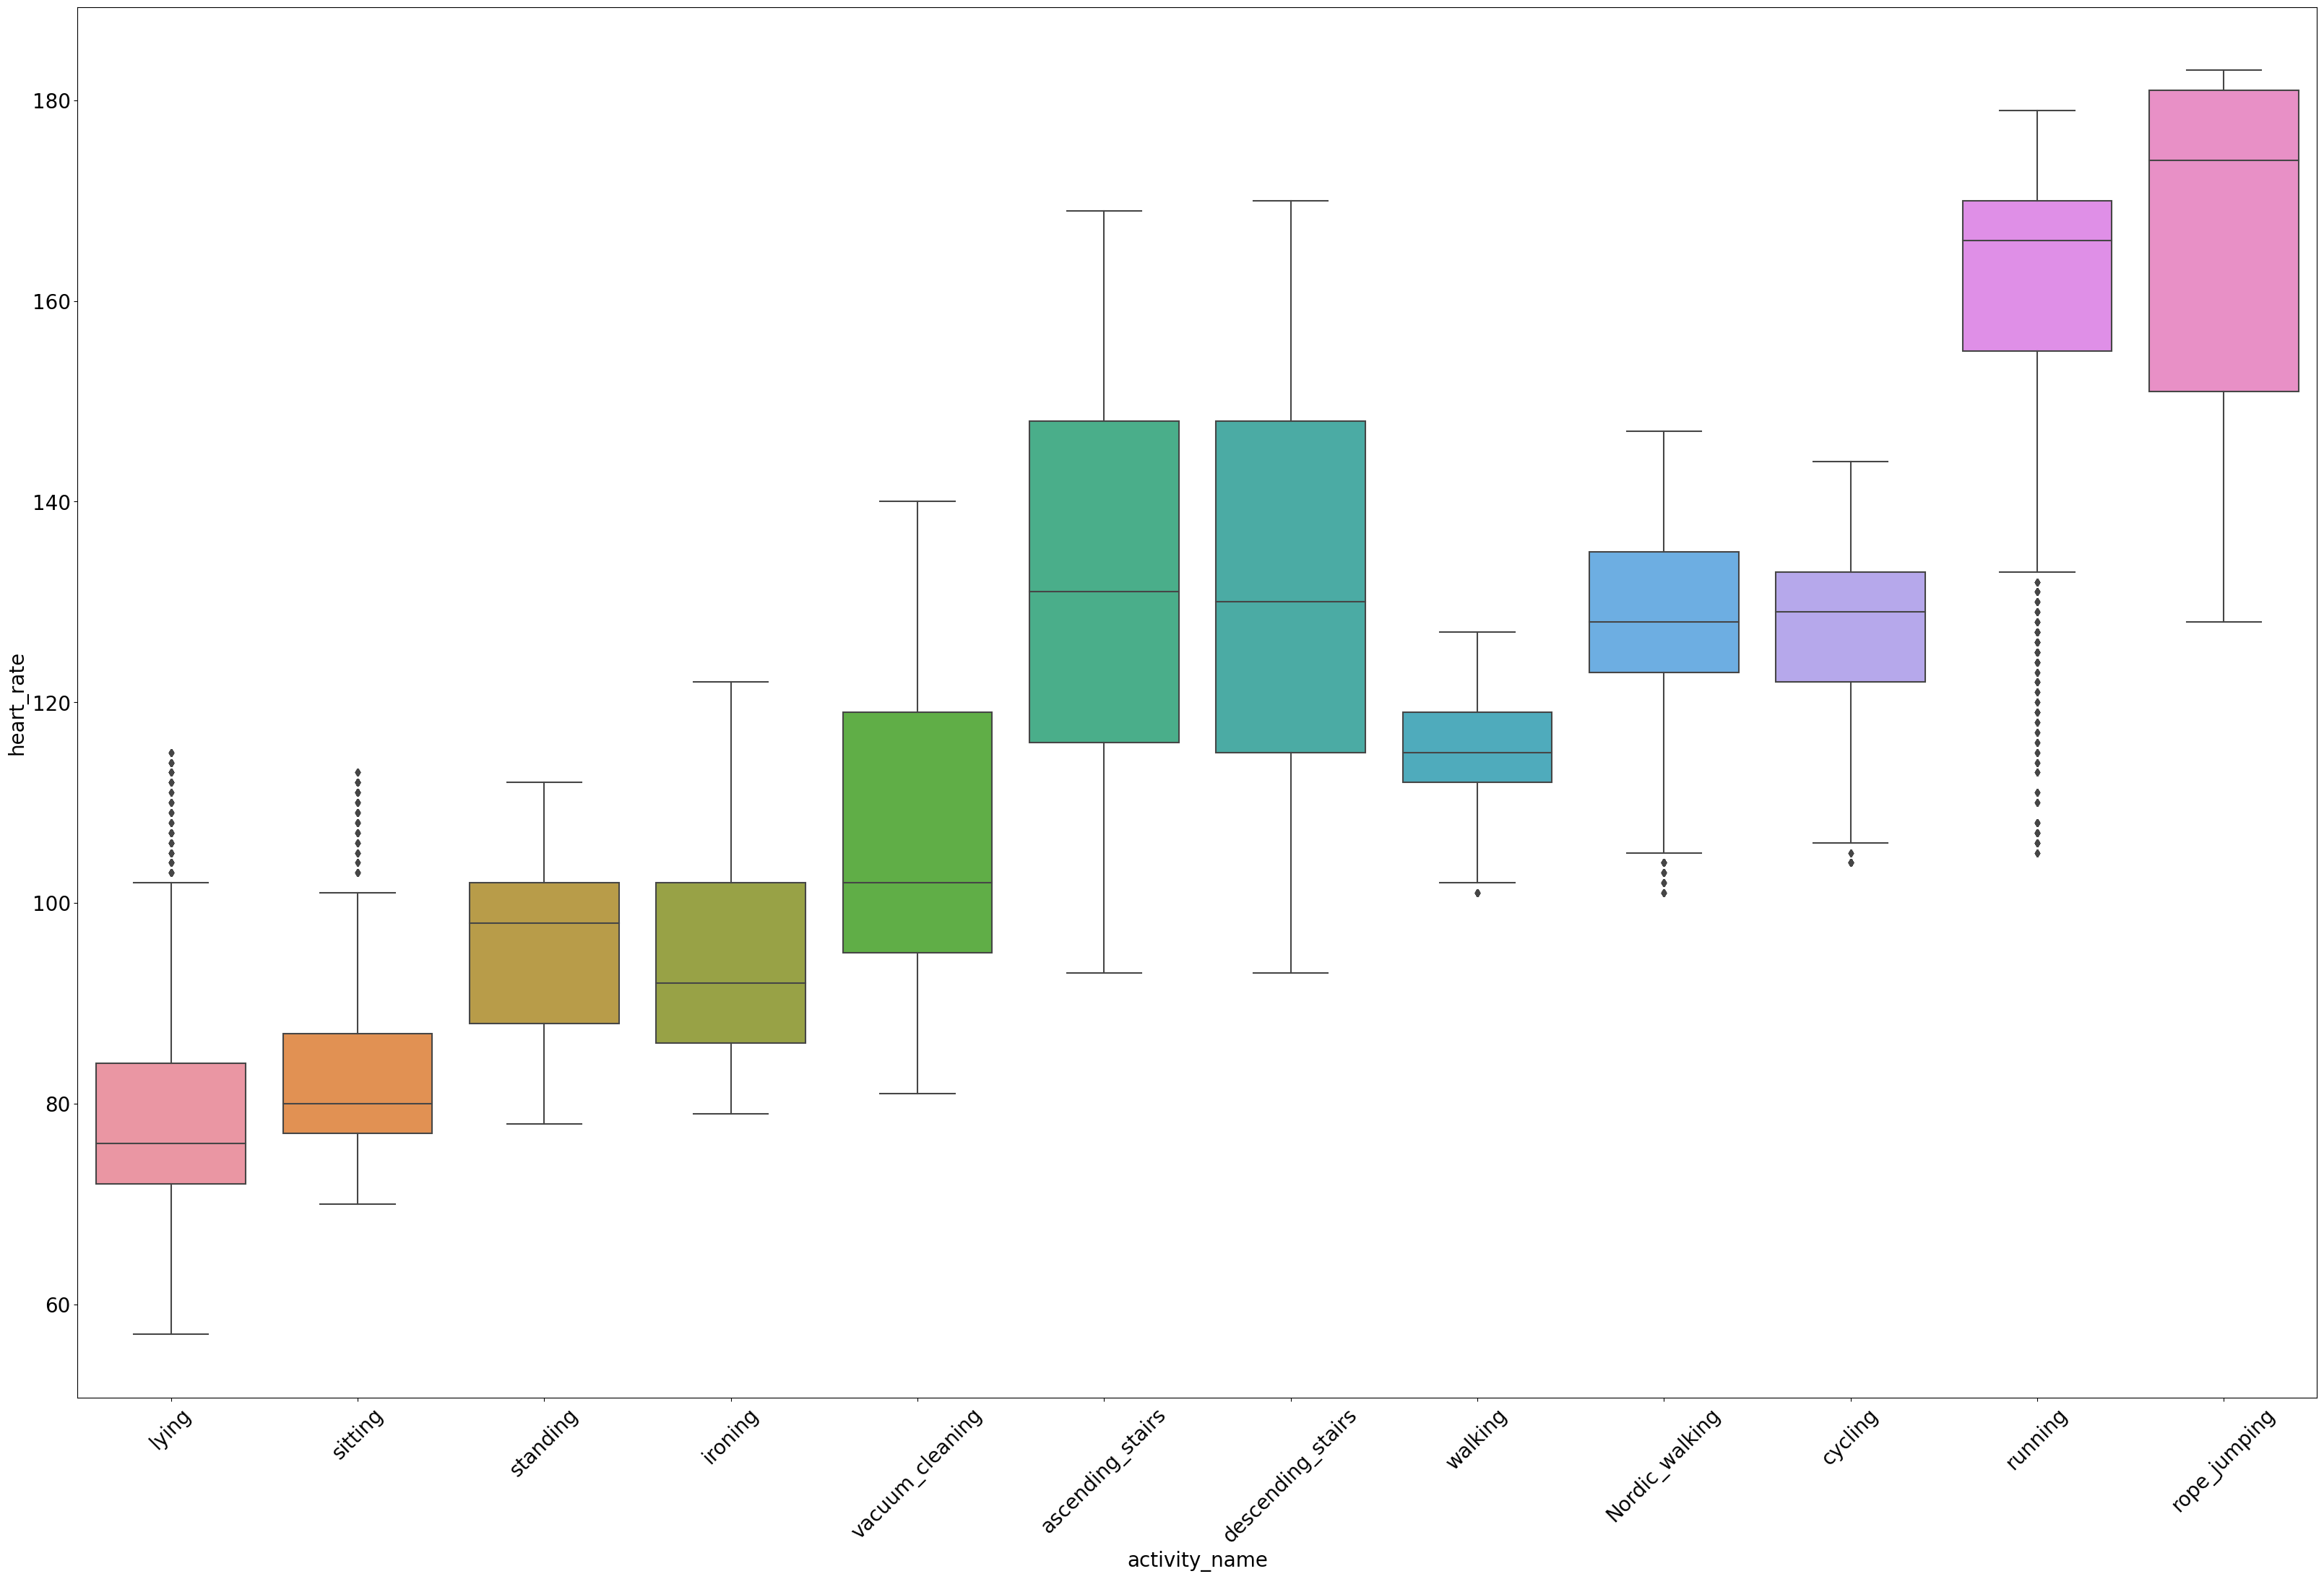

In [688]:
rcParams['figure.figsize'] = 40,25
ax=sns.boxplot(x="activity_name",y="heart_rate",data=train)
ax.set_xticklabels(ax.get_xticklabels(),rotation=45)# Rotating Text
plt.show()

  1.  Most of the activities have a skewed distribution for heart rate.<br>
  2. 'Nordic_walking','running' and 'cycling' have a lot of outliers on the lower side.<br>
  3.  Activities like 'lying','sitting' and 'standing' have a lot of outliers on the upper side.

* Boxplot of hand temperature grouped by activity type.

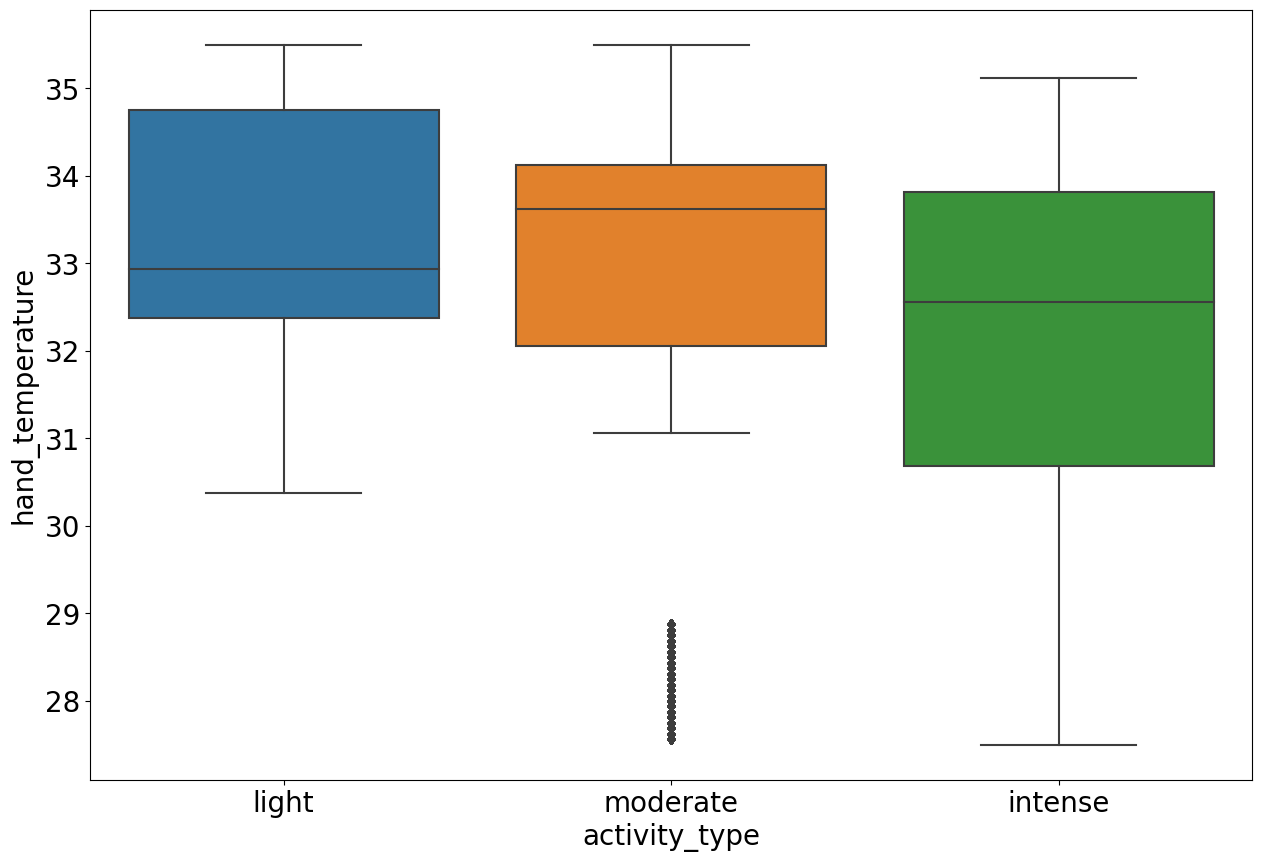

In [689]:
rcParams['figure.figsize'] = 15,10
ax=sns.boxplot(x="activity_type",y="hand_temperature",data=train)
ax.set_xticklabels(ax.get_xticklabels(),rotation=0)
plt.show()

1. Hand temperature of moderate activitie have a lot of outliers on the lower side.<br>
2. There doesn't seem to be much difference in temperatures between activities.

* Boxplot of hand temperature grouped by activity.

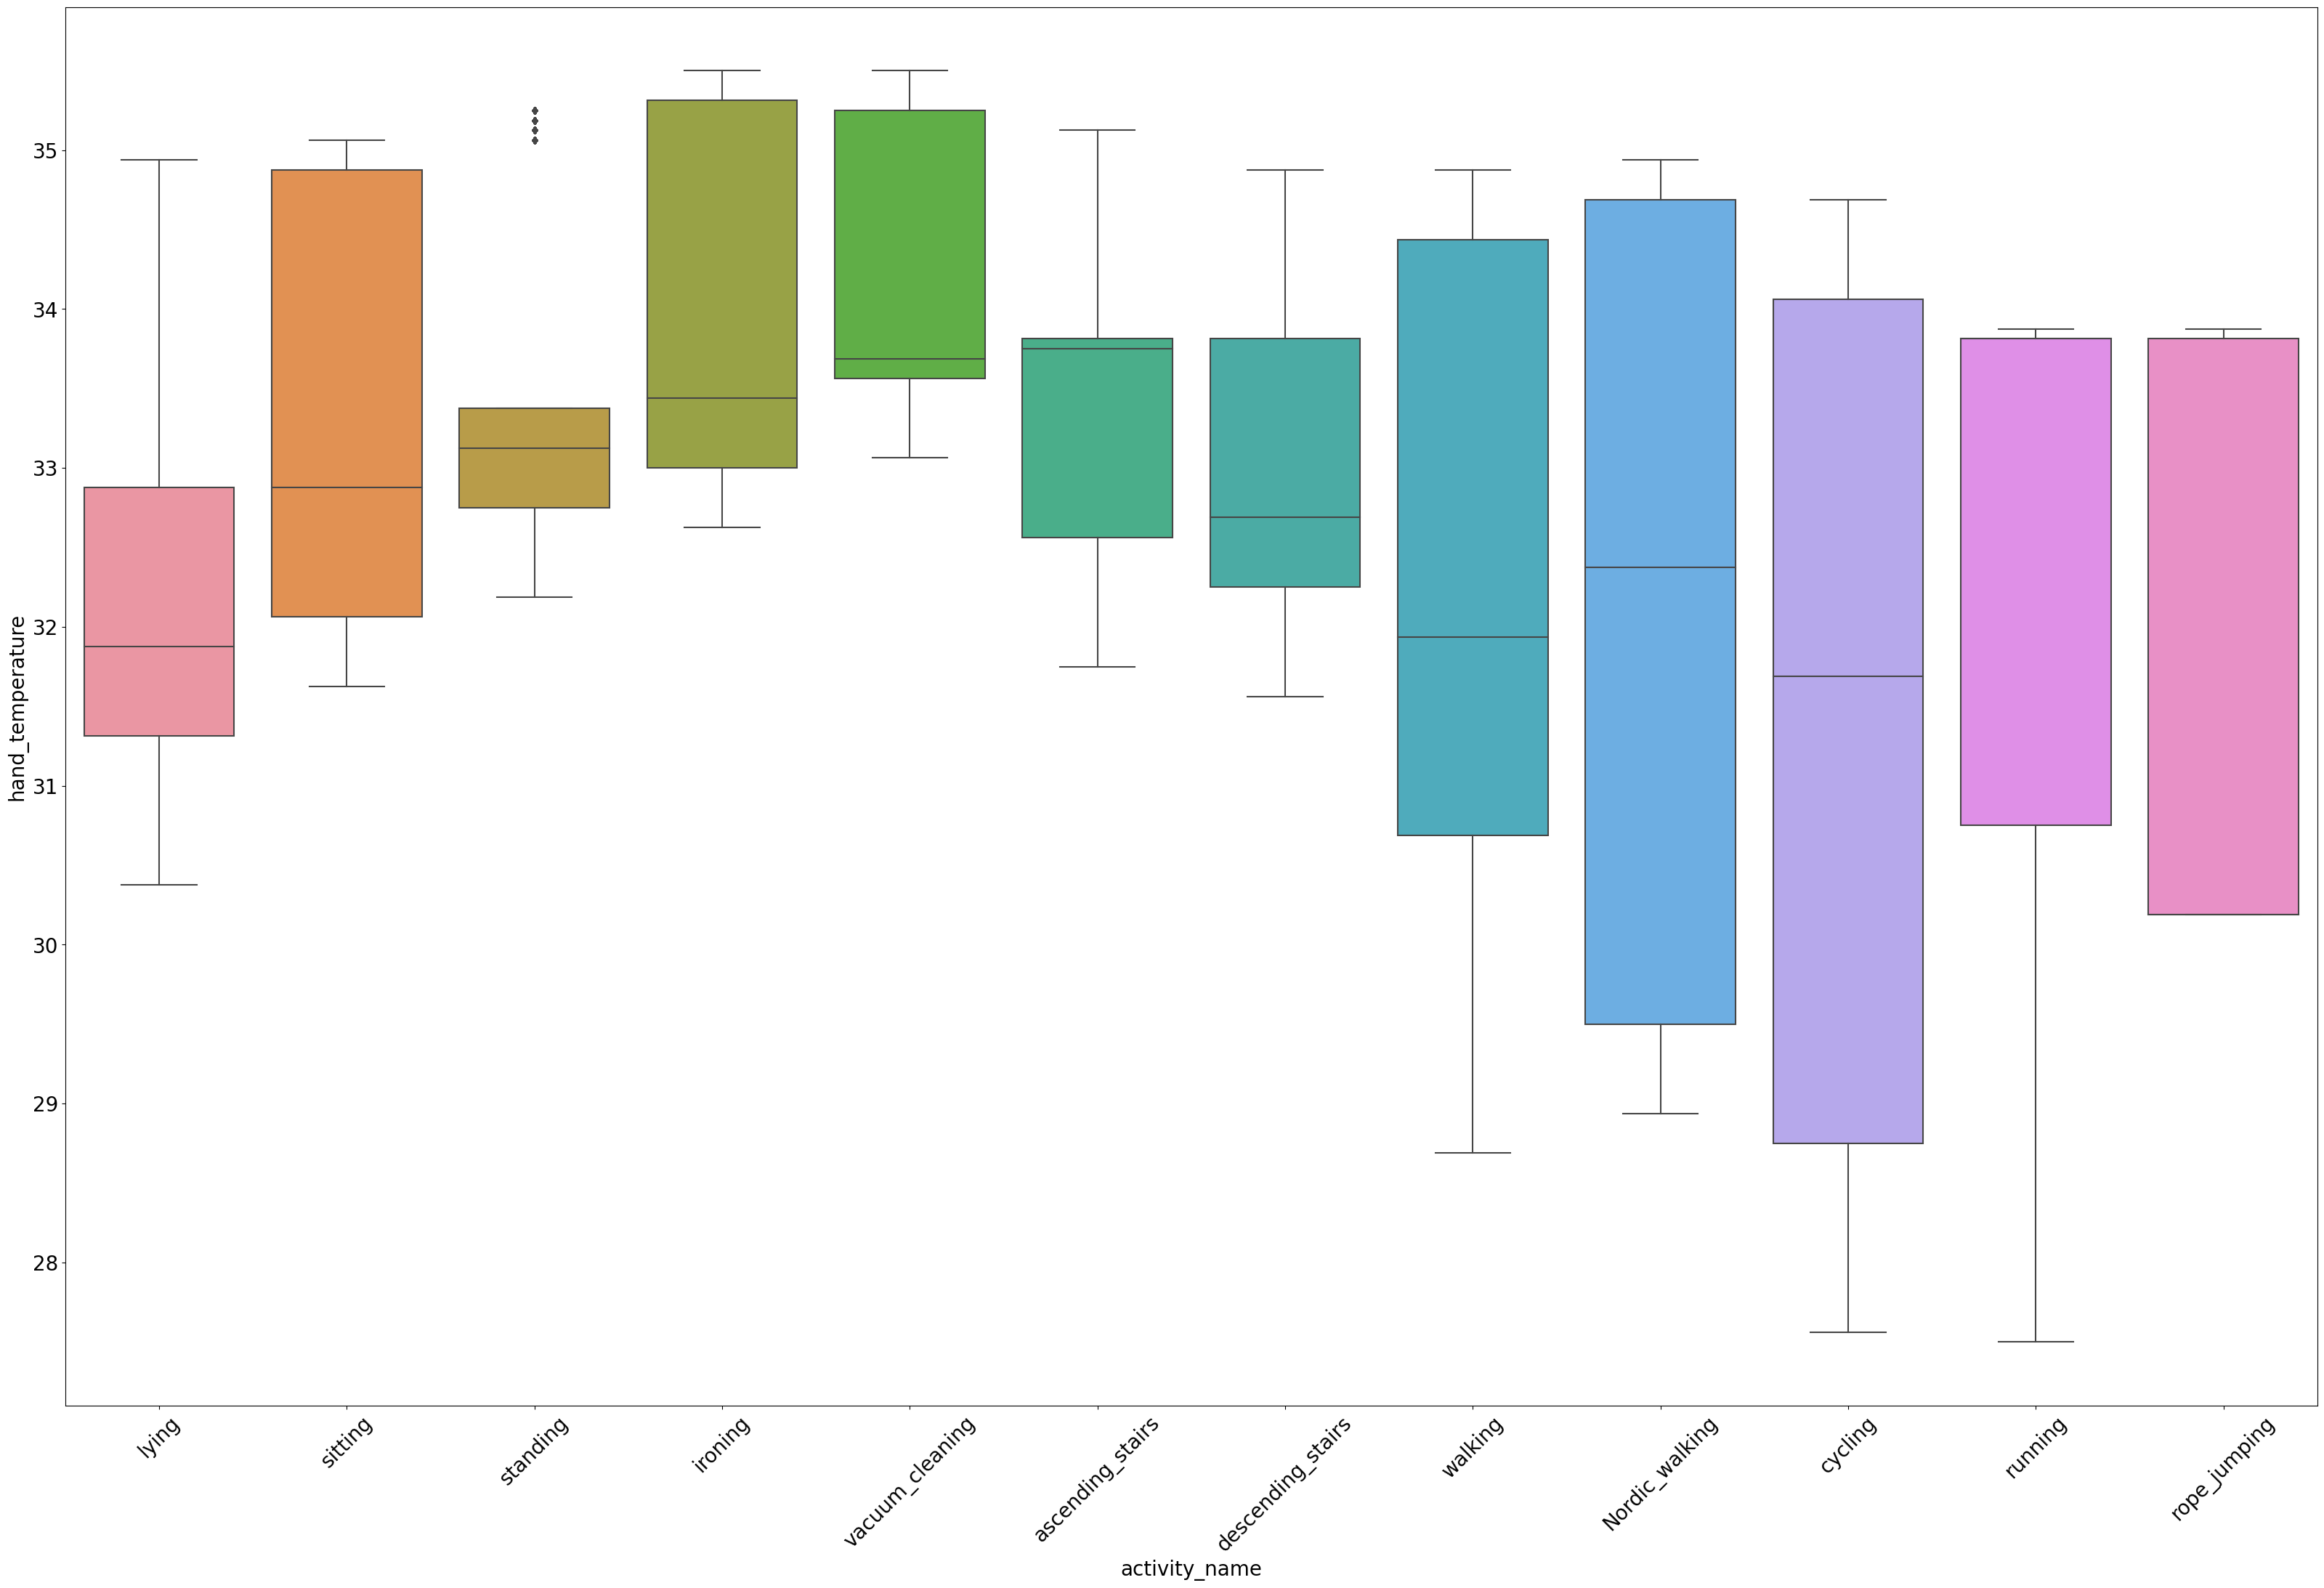

In [690]:
rcParams['figure.figsize'] = 40,25
ax=sns.boxplot(x="activity_name",y="hand_temperature",data=train)
ax.set_xticklabels(ax.get_xticklabels(),rotation=45)# Rotating Text
plt.show()

1. Hand temperature data of 'playing_soccer' seems to have a very pronounced positive skew.<br>
2. "car_driving" and "watching_tv" have the least dispersion in hand temperature.

* Boxplot of ankle temperature grouped by activity_type

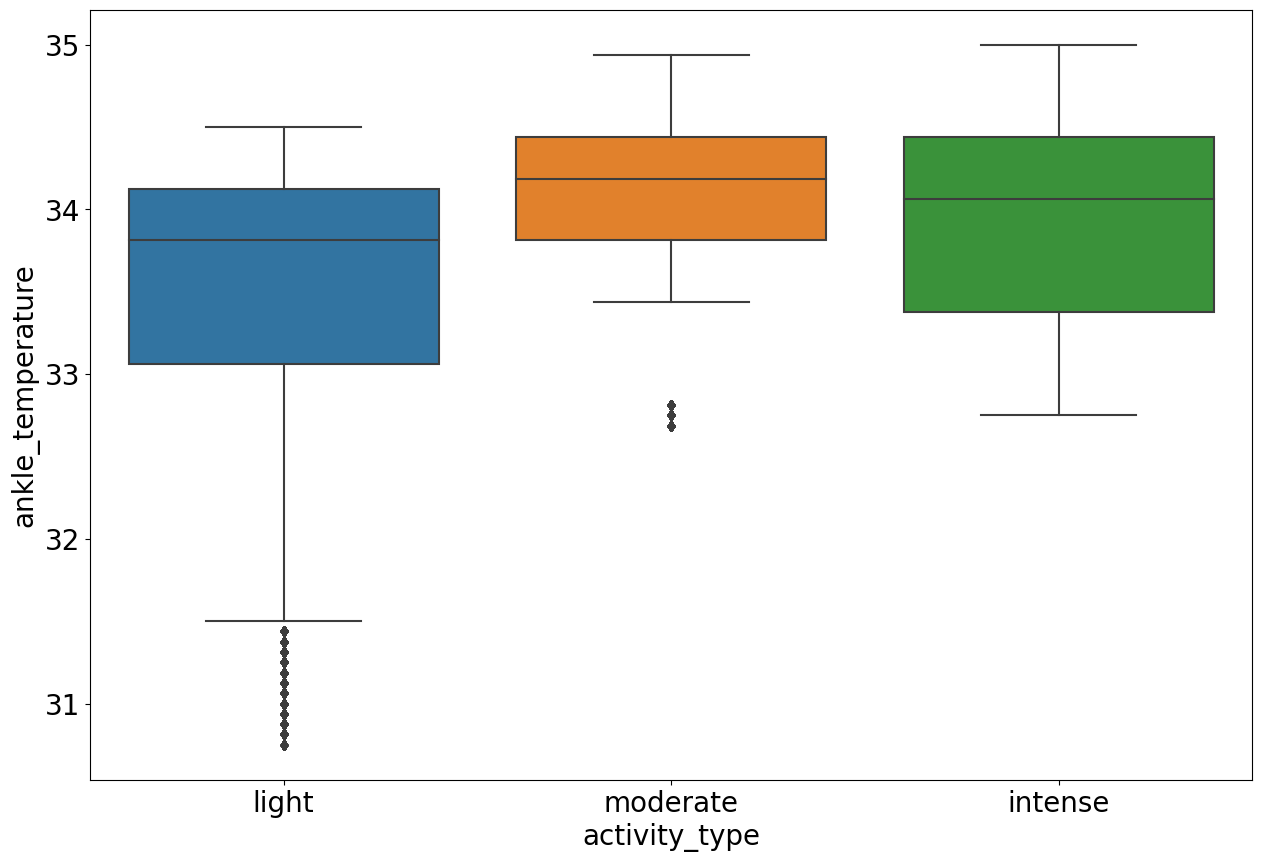

In [691]:
rcParams['figure.figsize'] = 15,10
ax=sns.boxplot(x="activity_type",y="ankle_temperature",data=train)
ax.set_xticklabels(ax.get_xticklabels(),rotation=0) 
plt.show()

1. Ankle temperature of light and moderate activitie have  outliers on the lower side.<br>
2. There doesn't seem to be much difference in temperatures between activities.

* Boxplot of ankle temperature grouped by activity

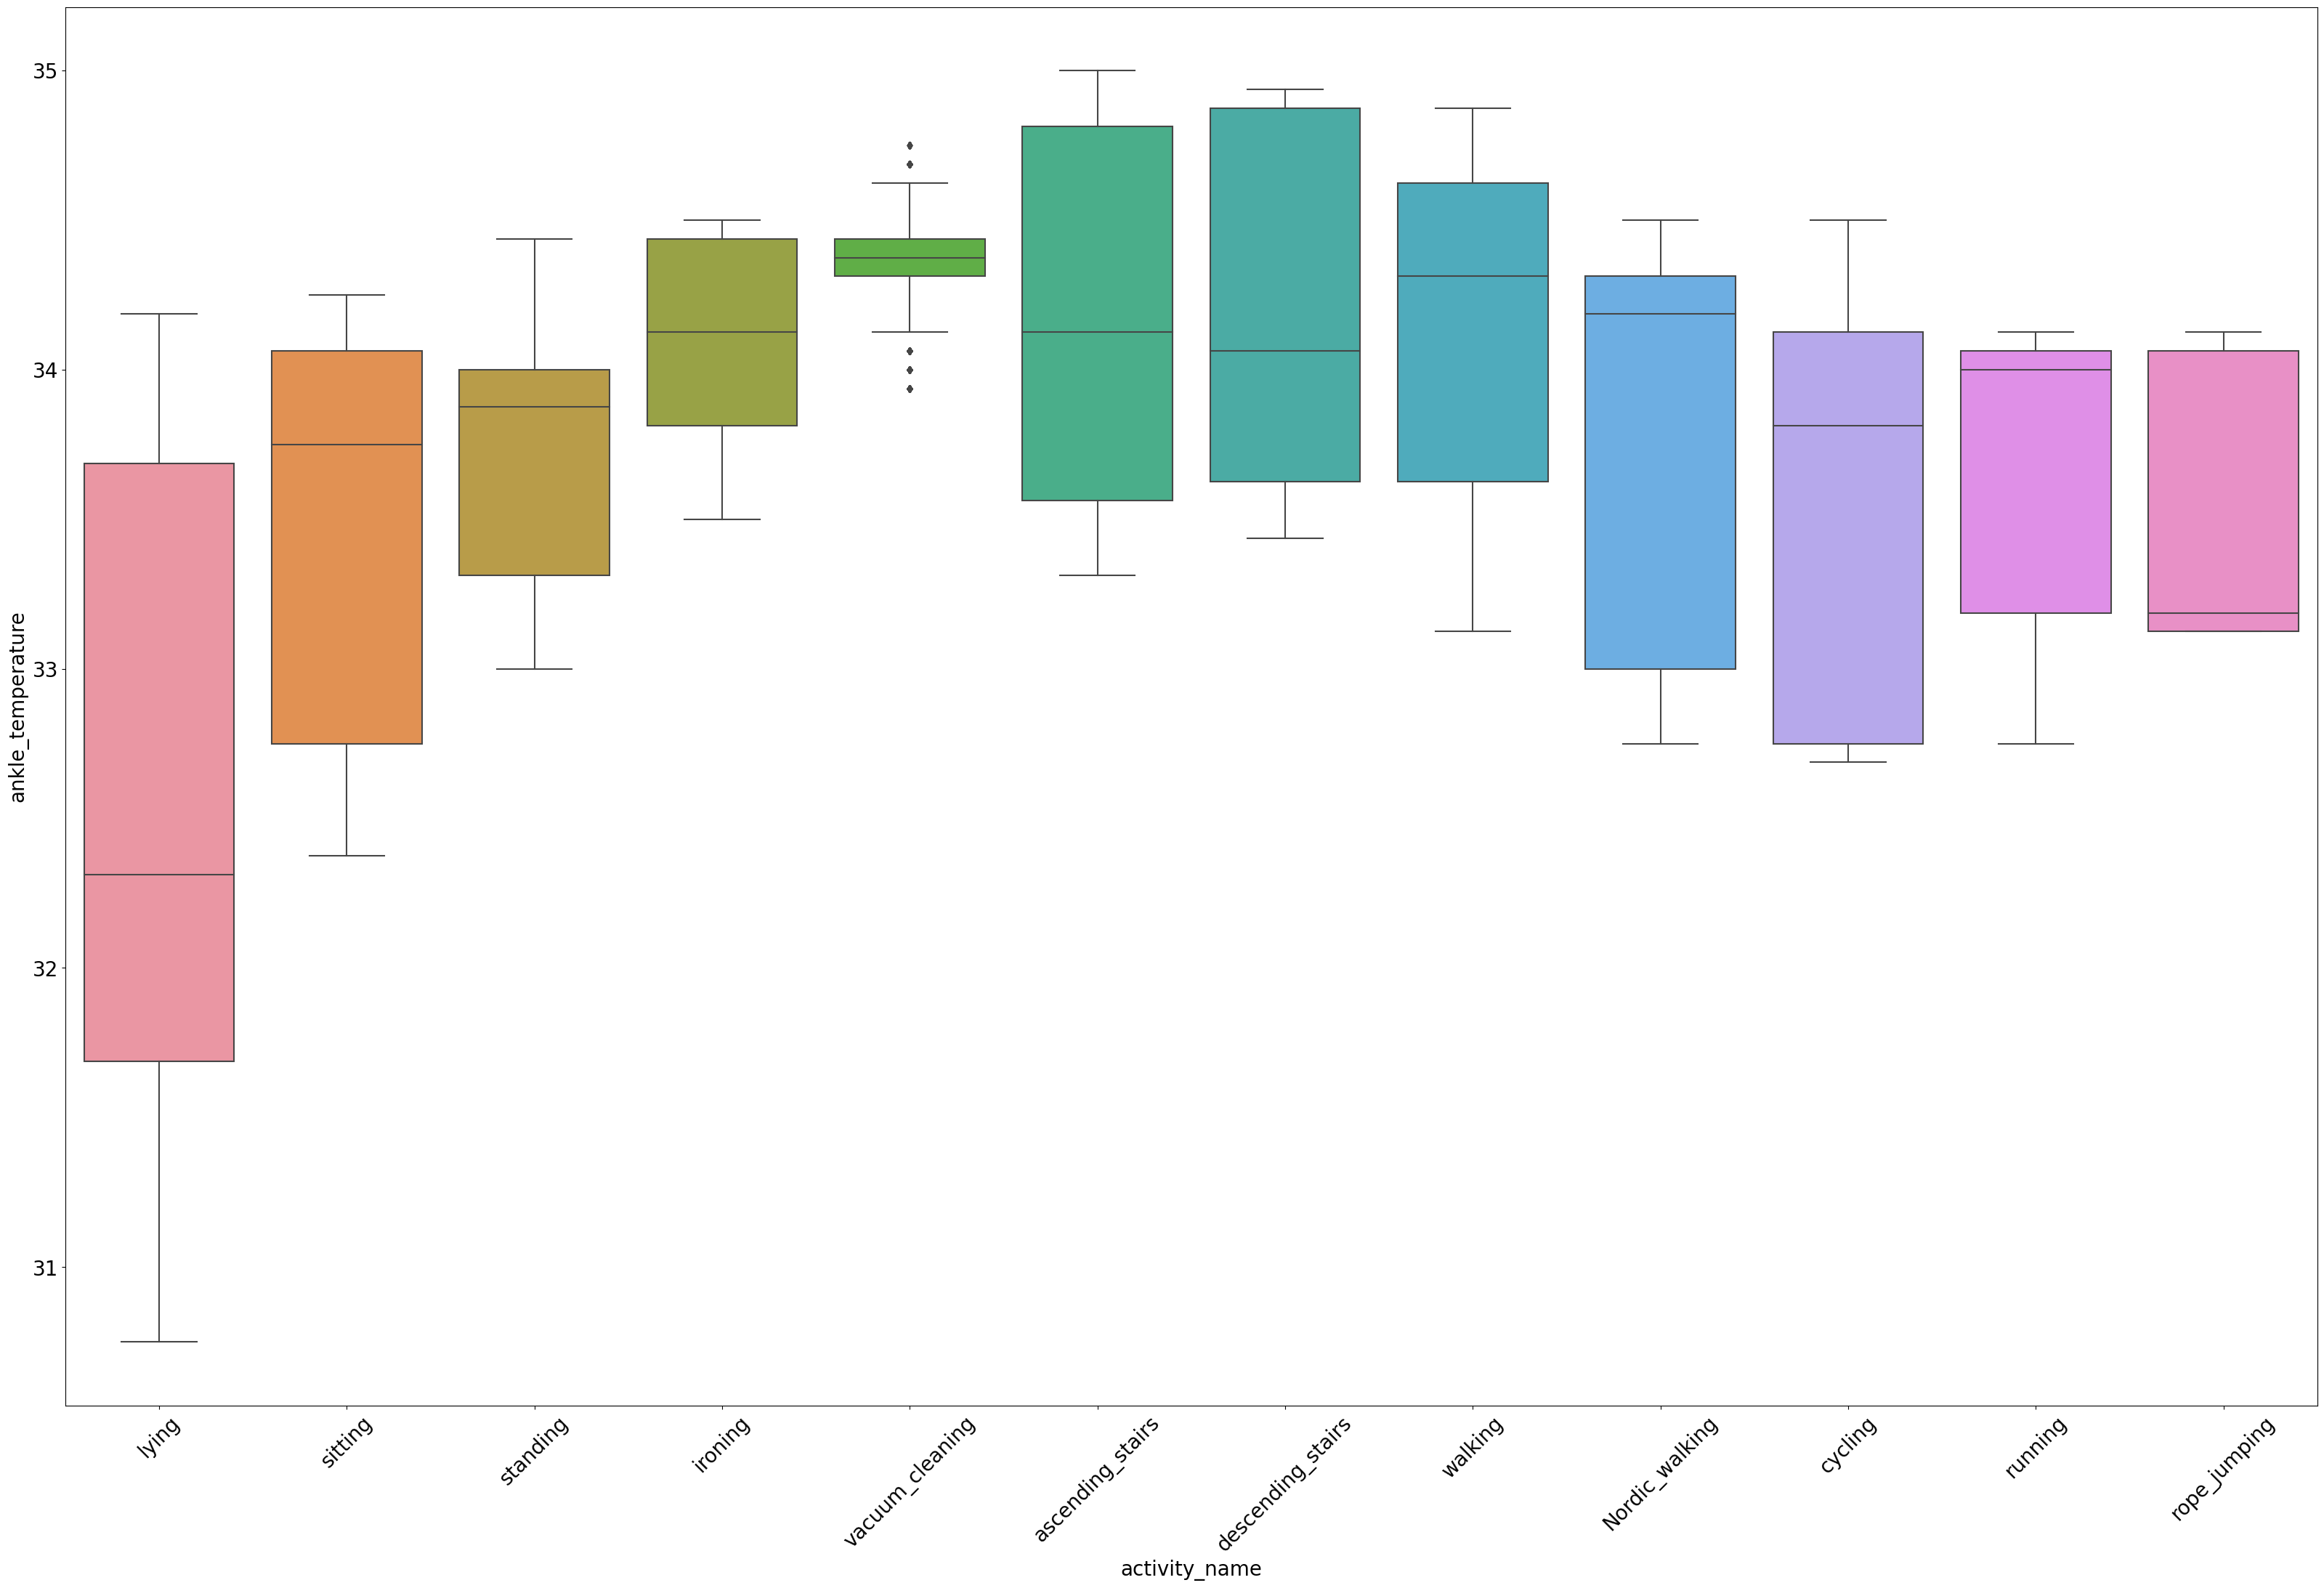

In [692]:
rcParams['figure.figsize'] = 40,25
ax=sns.boxplot(x="activity_name",y="ankle_temperature",data=train)
ax.set_xticklabels(ax.get_xticklabels(),rotation=45) # Rotating Text
plt.show()

1. For ankle temperature, 'playing_soccer' has the least dispersed distribution.<br>
2. Outliers are mostly present in 'vacuum_cleaning' on the lower side. 

* Boxplot of chest temperature grouped by activity_type

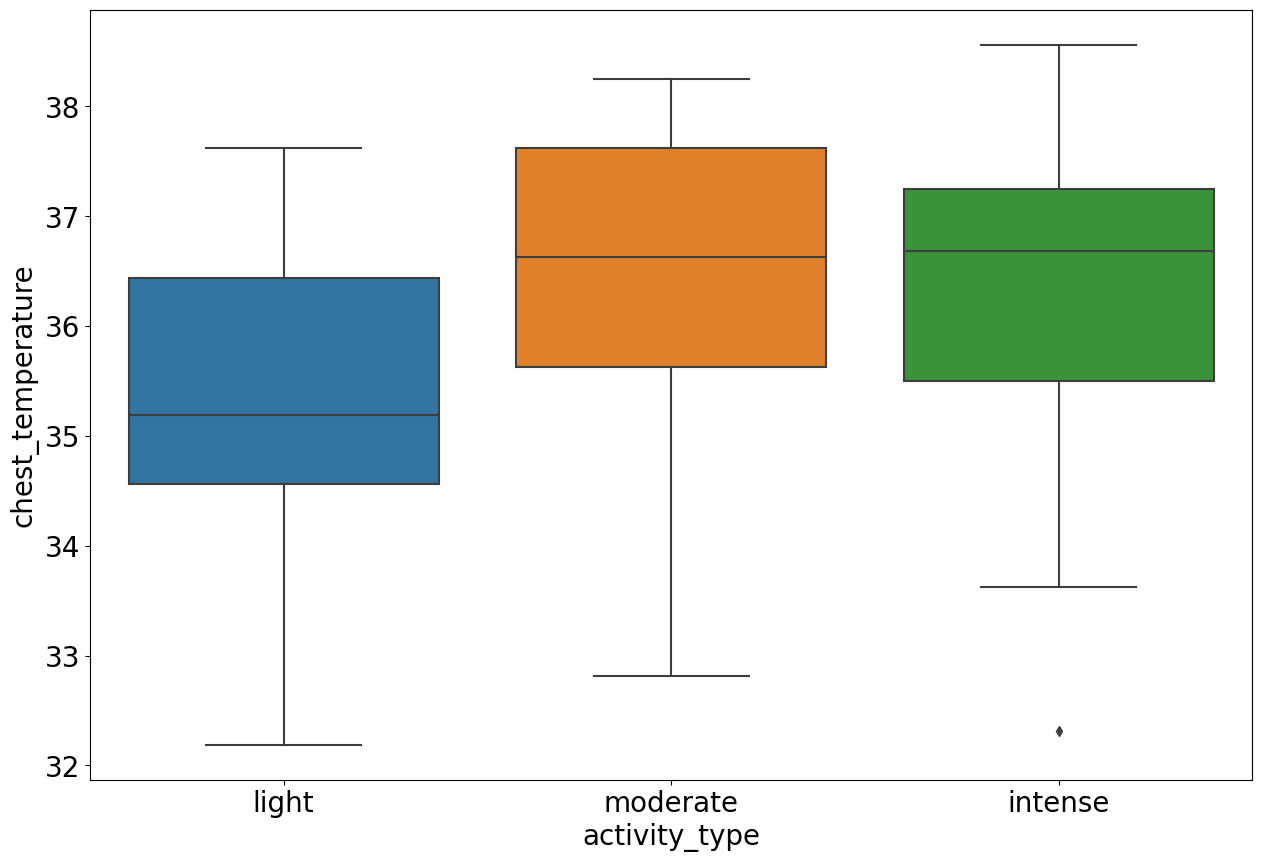

In [693]:
rcParams['figure.figsize'] = 15,10
ax=sns.boxplot(x="activity_type",y="chest_temperature",data=train)
ax.set_xticklabels(ax.get_xticklabels(),rotation=0) 
plt.show()

1. For chest temperatures, only the 'intense' activity type has an outlier.<br>
2. For this feature as well, there doesn't seem to be much difference between <br>
   temperatures.

* Boxplot of chest temperature grouped by activity.

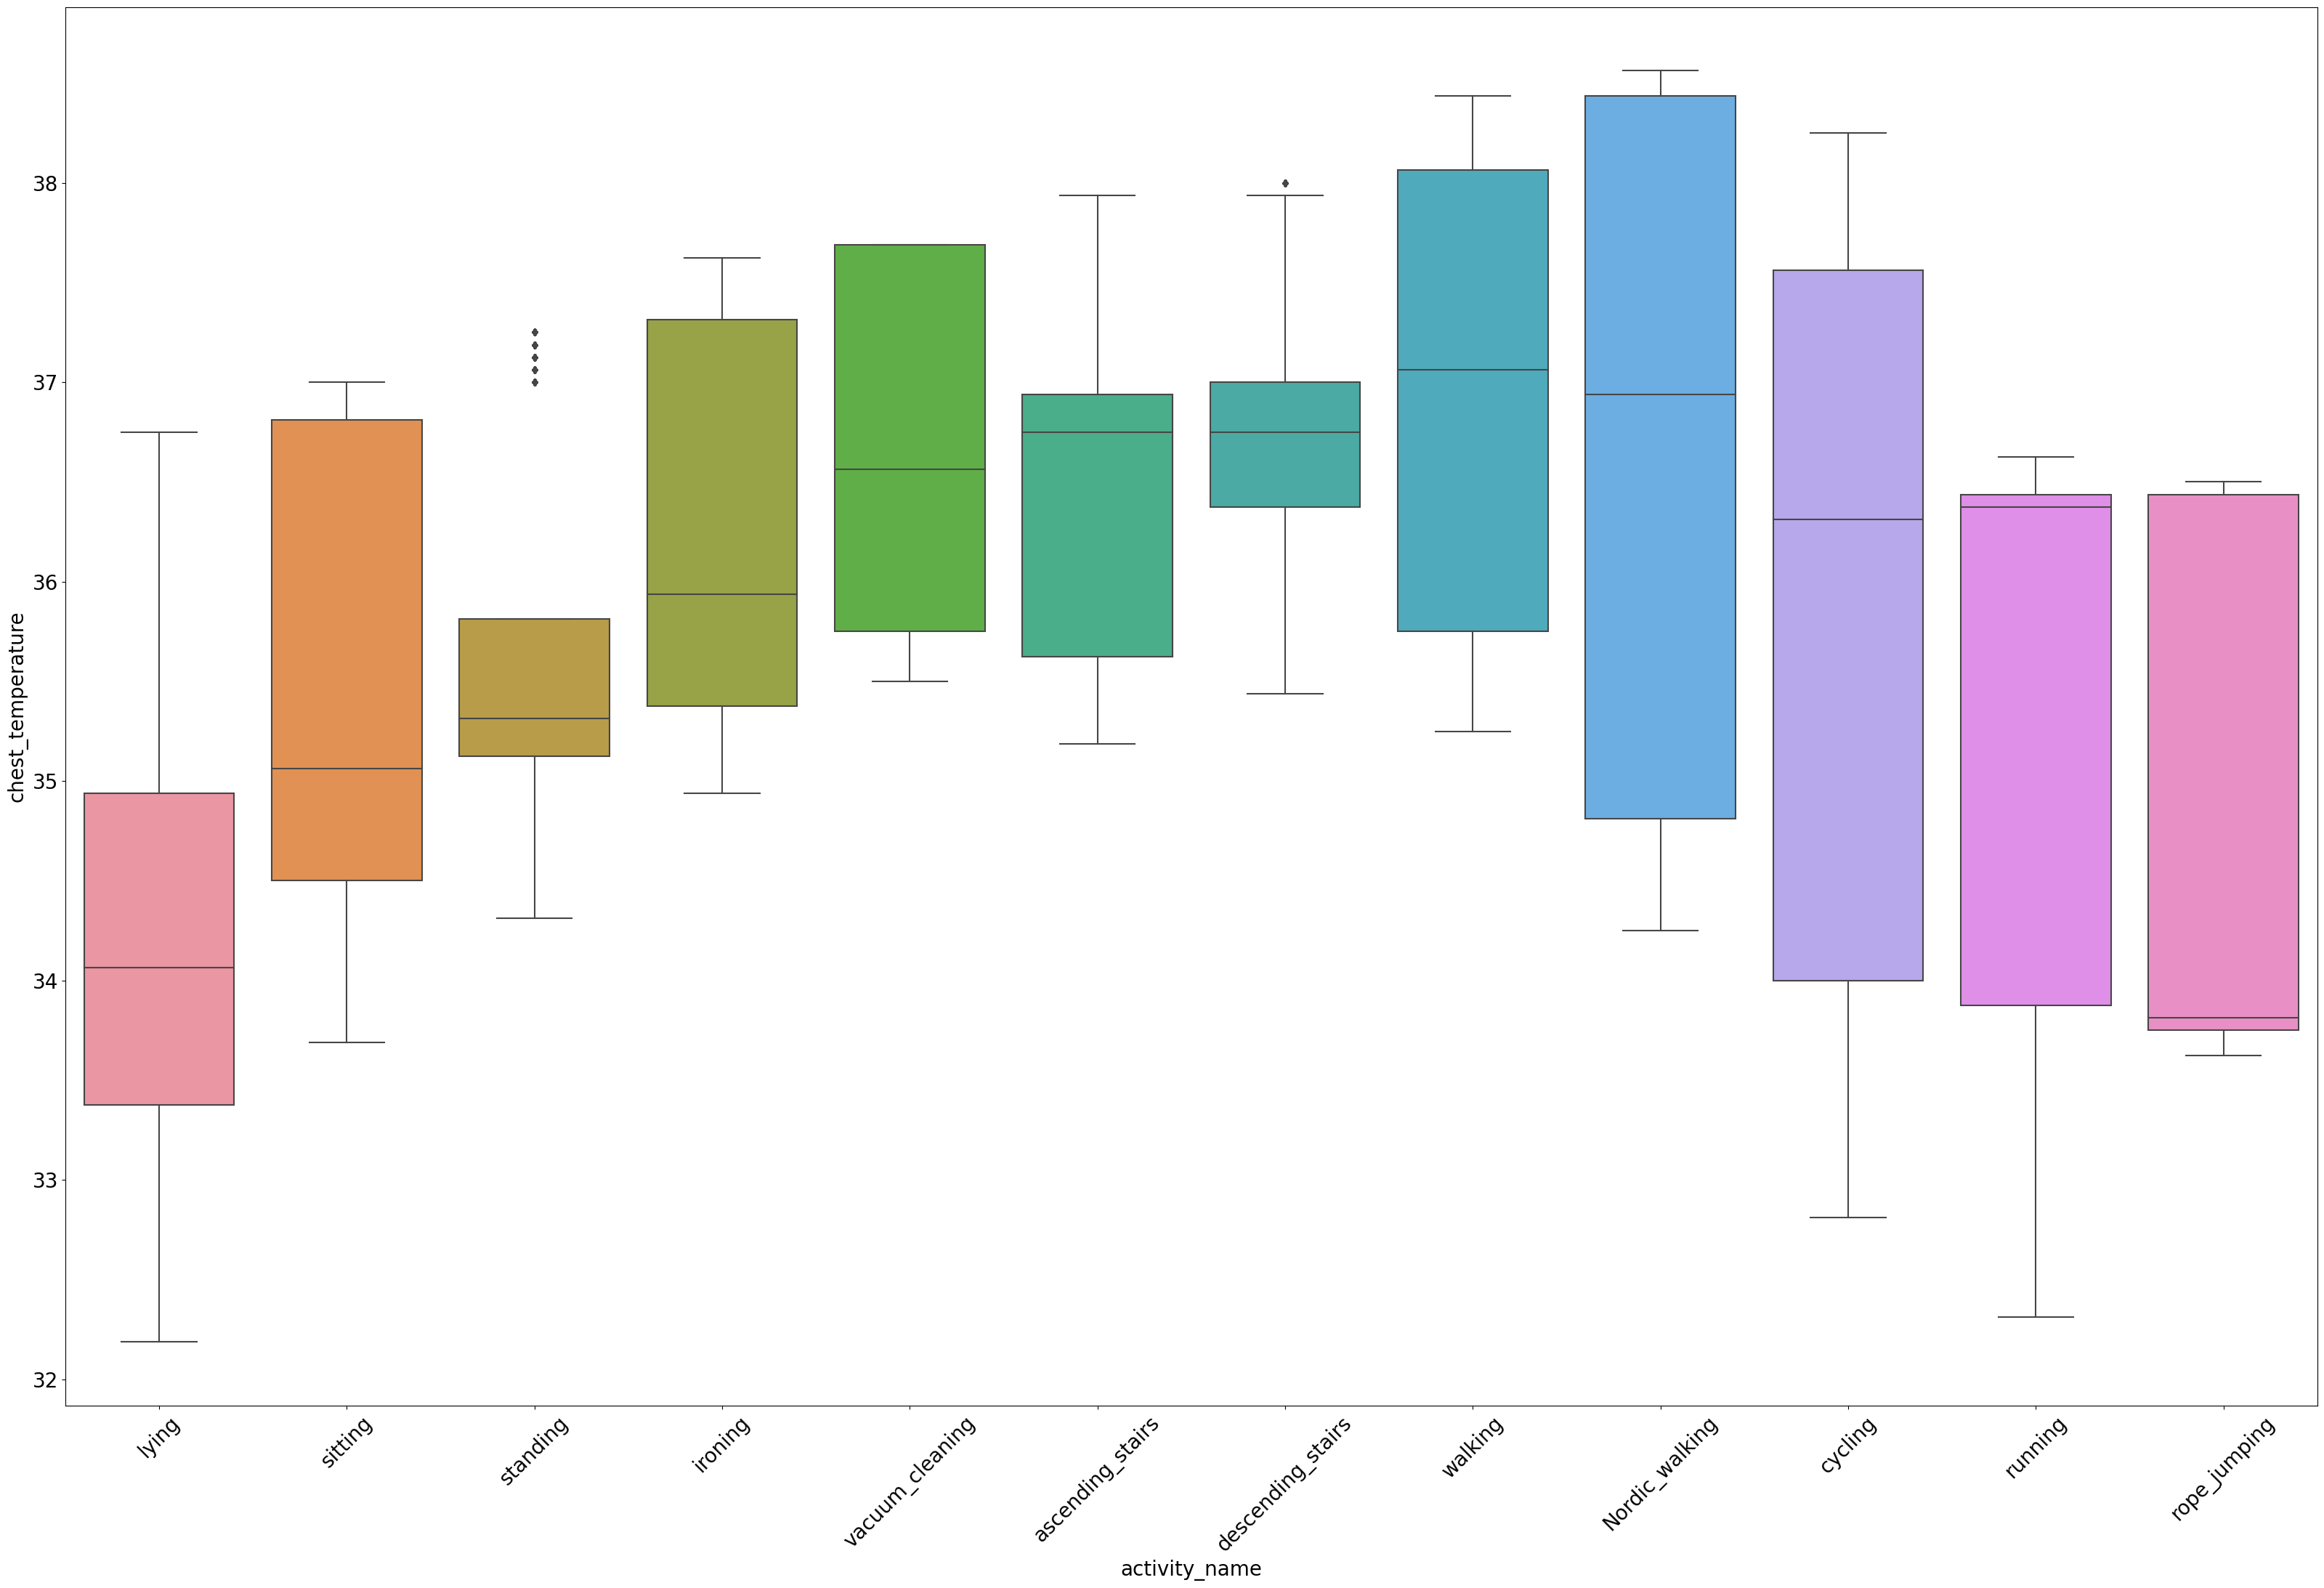

In [694]:
rcParams['figure.figsize'] = 40,25
ax=sns.boxplot(x="activity_name",y="chest_temperature",data=train)
ax.set_xticklabels(ax.get_xticklabels(),rotation=45) # Rotating Text
plt.show()

1. Most of the activities seem to have a skewed distribution for chest temperature.<br>
2. 'car_driving' and 'watching_tv' seem to have the least dispersed distribution.

* A joint plot trying to investigate possibility of correlation between heart rate <br>
  and chest temperature.

<Figure size 4000x2500 with 0 Axes>

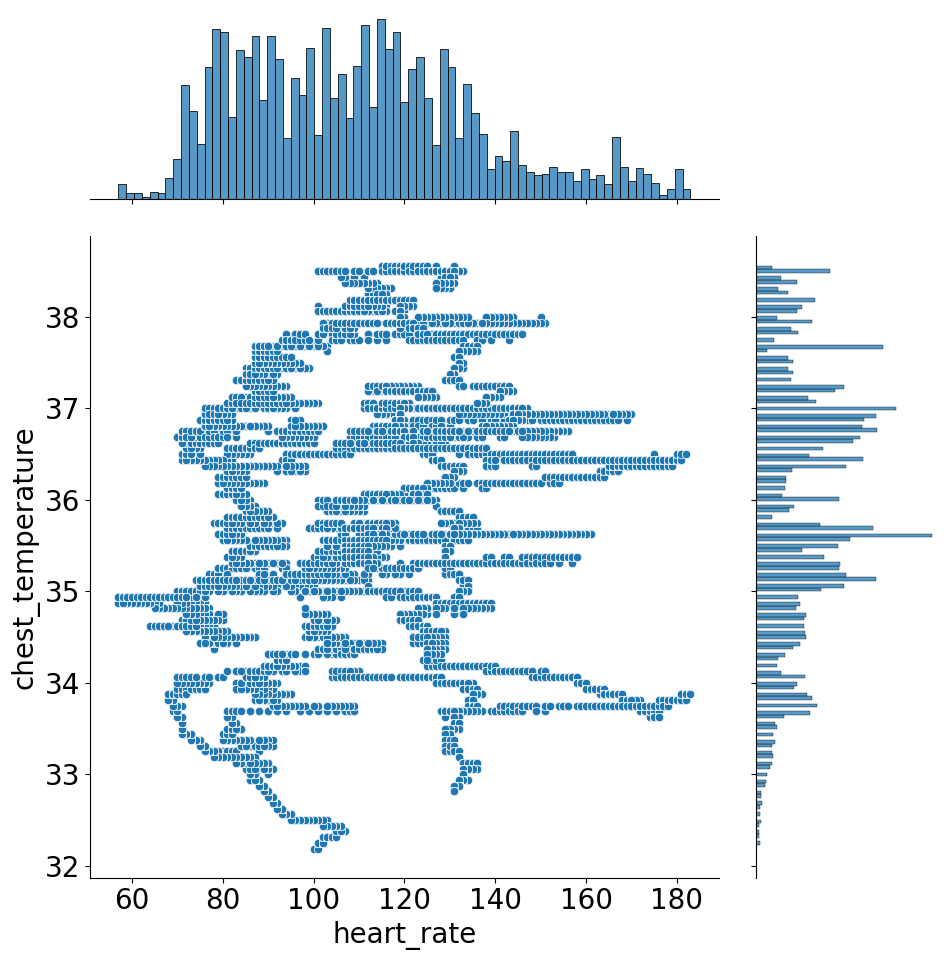

In [695]:
plt.clf()
rcParams['font.size'] = 20 # Setting the text and number font size
g = sns.JointGrid(data=train, x="heart_rate", y="chest_temperature",
                  height=10,ratio=3)
g.plot_joint(sns.scatterplot,palette='colorblind')
g.plot_marginals(sns.histplot)
# ax.set_xticklabels(ax.get_xticklabels(),rotation=45) # Rotating Text
plt.show()

1. From the scatter plot, we see that there does not seem to be a correlation between<br>
   the two variables.<br>
2. The respective histograms indicate that both the features considered have <br>
   a multi-modal distribution.

### Descriptive Statistics<br>
Subject Details

In [696]:
display(subj_det)

,Subject ID,Sex,Age (years),Height (cm),Weight (kg),Resting HR (bpm),Max HR (bpm),Dominant hand,BMI
0,101,Male,27,182,83,75,193,right,25.057360
1,102,Female,25,169,78,74,195,right,27.309968
2,103,Male,31,187,92,68,189,right,26.309017
3,104,Male,24,194,95,58,196,right,25.241790
4,105,Male,26,180,73,70,194,right,22.530864
5,106,Male,26,183,69,60,194,right,20.603780
6,107,Male,23,173,86,60,197,right,28.734672
7,108,Male,32,179,87,66,188,left,27.152711
8,109,Male,31,168,65,54,189,right,23.030045


Mean of heart rate and temperatures for each activity

In [697]:
display(train.groupby(by='activity_name')[['heart_rate','chest_temperature','hand_temperature',
    'ankle_temperature']].mean())
discard = ['activity_id','activity','time_stamp','id']# Columns to exclude from descriptive statistics

,heart_rate,chest_temperature,hand_temperature,ankle_temperature
activity_name,,,,
Nordic_walking,128.934574,36.640204,32.124192,33.778505
ascending_stairs,132.404398,36.586821,33.381660,34.146043
cycling,127.117356,35.894279,31.493273,33.617997
descending_stairs,130.733971,36.701044,33.195439,34.147815
ironing,94.586717,36.162343,33.845229,34.103435
lying,78.609097,34.449084,32.508522,32.690584
rope_jumping,165.084261,34.773034,31.562491,33.499627
running,158.613734,35.262980,32.372712,33.646088
sitting,82.242313,35.238913,33.025149,33.370173


Creating table with only relevant columns

In [698]:
train_trimmed = train[[i for i in train.columns if i not in discard]]

Descriptive info of relevant feature

In [699]:
display(train_trimmed.describe())

,heart_rate,hand_temperature,hand_3D_acceleration_16_x,hand_3D_acceleration_16_y,hand_3D_acceleration_16_z,hand_3D_gyroscope_x,hand_3D_gyroscope_y,hand_3D_gyroscope_z,hand_3D_magnetometer_x,hand_3D_magnetometer_y,...,ankle_3D_acceleration_16_x,ankle_3D_acceleration_16_y,ankle_3D_acceleration_16_z,ankle_3D_gyroscope_x,ankle_3D_gyroscope_y,ankle_3D_gyroscope_z,ankle_3D_magnetometer_x,ankle_3D_magnetometer_y,ankle_3D_magnetometer_z,rolling_mean
count,84798.000000,922733.000000,922733.000000,922733.000000,922733.000000,922733.000000,922733.000000,922733.000000,922733.000000,922733.000000,...,924261.000000,924261.000000,924261.000000,924261.000000,924261.000000,924261.000000,924261.000000,924261.000000,924261.000000,628674.000000
mean,109.912769,32.885818,-4.701216,4.867122,3.819557,0.012205,0.028274,-0.000027,20.935601,-19.068579,...,9.377596,0.188150,-2.361436,0.007019,-0.029152,0.019965,-34.292921,-0.243321,16.765524,-0.512319
std,26.029426,1.708249,6.073816,5.386418,3.675067,1.251699,0.887466,1.550689,25.717188,24.385500,...,6.006841,7.470235,3.727983,1.022017,0.571440,1.940598,21.381194,23.717646,21.612666,3.767756
min,57.000000,27.500000,-90.760600,-65.538700,-38.907800,-27.804400,-7.609010,-14.264700,-103.941000,-200.043000,...,-66.308500,-155.356000,-158.926000,-13.385600,-7.807450,-14.019600,-172.865000,-137.908000,-102.716000,-9.929866
25%,89.000000,31.937500,-8.831980,2.247180,1.721670,-0.387488,-0.222837,-0.354068,2.499940,-33.442100,...,8.465960,-2.178640,-3.603550,-0.201214,-0.130252,-0.433755,-45.705600,-15.123500,2.088300,-1.387639
50%,109.000000,33.000000,-5.029430,4.385290,3.721100,-0.005547,0.008087,-0.004496,22.012300,-19.829700,...,9.572440,0.129326,-2.083400,0.003077,-0.006023,-0.003808,-35.768600,-0.349413,20.468600,0.531078
75%,127.000000,34.125000,-0.525061,7.182090,6.407160,0.338614,0.279915,0.393650,40.078900,-2.523220,...,10.177500,1.927560,-0.649289,0.095482,0.085158,0.065000,-17.365300,17.762500,30.407100,1.790130
max,183.000000,35.500000,42.891600,154.576000,76.639600,26.415800,13.251000,14.338400,133.830000,94.127400,...,155.166000,156.190000,156.730000,13.142500,6.410380,14.482700,91.551600,94.247800,122.521000,9.575286


Correlation table of relevant features

In [700]:
display(train_trimmed.corr()) 

,heart_rate,hand_temperature,hand_3D_acceleration_16_x,hand_3D_acceleration_16_y,hand_3D_acceleration_16_z,hand_3D_gyroscope_x,hand_3D_gyroscope_y,hand_3D_gyroscope_z,hand_3D_magnetometer_x,hand_3D_magnetometer_y,...,ankle_3D_acceleration_16_x,ankle_3D_acceleration_16_y,ankle_3D_acceleration_16_z,ankle_3D_gyroscope_x,ankle_3D_gyroscope_y,ankle_3D_gyroscope_z,ankle_3D_magnetometer_x,ankle_3D_magnetometer_y,ankle_3D_magnetometer_z,rolling_mean
heart_rate,1.000000,-0.220115,-0.368908,0.123662,-0.206407,0.034125,0.047003,0.002771,0.347414,-0.217862,...,0.311552,0.289636,-0.080693,-0.005898,-0.018926,0.008108,-0.307893,-0.369844,-0.057315,0.579733
hand_temperature,-0.220115,1.000000,0.071354,0.071838,0.005334,-0.010433,0.007138,0.008105,-0.110104,-0.105941,...,0.004523,-0.045370,-0.051711,-0.001608,0.021266,0.001464,0.057385,0.136824,0.138307,-0.009403
hand_3D_acceleration_16_x,-0.368908,0.071354,1.000000,-0.091416,0.139061,0.044145,-0.040104,0.045492,-0.502595,0.074007,...,-0.336574,-0.174272,0.002326,0.039992,0.003158,0.141434,0.082758,0.278140,-0.079003,-0.571152
hand_3D_acceleration_16_y,0.123662,0.071838,-0.091416,1.000000,0.047659,0.140829,-0.015908,0.004832,-0.086517,-0.319862,...,0.057531,0.119557,-0.058912,0.025796,-0.055020,-0.035959,-0.067586,-0.031052,0.034680,0.107191
hand_3D_acceleration_16_z,-0.206407,0.005334,0.139061,0.047659,1.000000,-0.005752,0.018573,-0.131349,-0.144001,0.162947,...,-0.126101,-0.055035,0.051972,0.032789,0.021021,0.037745,0.065555,0.089663,-0.017519,-0.240658
hand_3D_gyroscope_x,0.034125,-0.010433,0.044145,0.140829,-0.005752,1.000000,-0.276027,-0.134415,0.016470,-0.014092,...,0.014466,0.000289,-0.015796,0.000860,-0.028087,0.109433,0.016939,-0.050119,-0.000201,-0.005275
hand_3D_gyroscope_y,0.047003,0.007138,-0.040104,-0.015908,0.018573,-0.276027,1.000000,-0.079495,-0.047280,-0.030878,...,0.037578,0.009389,-0.014927,0.061826,0.065140,0.001467,-0.021981,-0.037537,-0.015755,0.008782
hand_3D_gyroscope_z,0.002771,0.008105,0.045492,0.004832,-0.131349,-0.134415,-0.079495,1.000000,-0.023344,-0.017130,...,-0.040842,0.060287,0.040990,-0.046875,-0.117540,-0.197402,-0.086227,0.128066,0.048330,0.020011
hand_3D_magnetometer_x,0.347414,-0.110104,-0.502595,-0.086517,-0.144001,0.016470,-0.047280,-0.023344,1.000000,0.116401,...,0.172099,0.212487,0.045909,0.067025,-0.066221,0.080303,-0.010844,-0.407286,-0.125300,0.352499
hand_3D_magnetometer_y,-0.217862,-0.105941,0.074007,-0.319862,0.162947,-0.014092,-0.030878,-0.017130,0.116401,1.000000,...,-0.239876,-0.081233,-0.050187,0.070581,-0.034002,0.059869,0.320043,0.100305,-0.326632,-0.288481


Variance of each axis of acceleration grouped by activities

In [701]:
coordinates = [i for i in train.columns if 'acceleration' in i]
display(train.groupby(by='activity_name')[coordinates].var())

,hand_3D_acceleration_16_x,hand_3D_acceleration_16_y,hand_3D_acceleration_16_z,chest_3D_acceleration_16_x,chest_3D_acceleration_16_y,chest_3D_acceleration_16_z,ankle_3D_acceleration_16_x,ankle_3D_acceleration_16_y,ankle_3D_acceleration_16_z
activity_name,,,,,,,,,
Nordic_walking,25.629540,58.398422,10.603472,2.575901,15.242082,6.148342,33.484057,92.289911,15.376649
ascending_stairs,23.543054,7.566316,5.824274,2.765901,10.775441,5.624425,42.033634,55.288195,28.013199
cycling,17.791446,15.649830,9.939227,0.715780,3.711593,4.622890,17.858721,12.164733,3.018095
descending_stairs,24.243241,11.550501,12.489337,2.984501,21.431527,4.440417,47.242317,70.014202,25.787439
ironing,10.310193,10.363109,13.358504,2.033213,0.736907,4.374898,0.174704,1.796946,1.696242
lying,15.855200,13.097997,13.166171,4.153232,6.062105,12.668459,7.192011,11.658936,12.639666
rope_jumping,75.582150,58.570550,38.432095,4.649561,247.259665,29.357327,118.280760,234.159169,50.880373
running,110.632062,212.062379,20.369313,8.078898,102.004097,9.118545,161.038054,228.653523,47.994581
sitting,10.279172,13.464679,10.087709,0.247896,0.804636,6.960005,6.838823,7.252916,8.381130


## Hypothesis Testing  

Based on the exploratory data analysis carried out, the following hypotheses are tested on  <br>
the test set:<br>
- Heart rate of moderate activities are greater than heart rate of light activities.<br>
- Heart rate of intense activities are greater than heart rate of light activities.<br>
- Chest acceleration along z axis is greater than that along x axis during lying.<br>
- Chest acceleration along x axis is greater than that along z axis during running.

Based on the EDA  we performed, it does not seem that the data is normally distributed. It is <br>
for this reason that Wilcoxon rank sum test was used to test the above hypothesis instead of the usual t-test which assumes that the samples follow a normal distribution.<br>
We test the above hypothesis using the confidence level of 5%.

### Hypothesis 1<br>
$H_0$(Null) : The heart rate during  moderate activities are the same or lower than that of light activities. <br>
$H_1$(Alternate) : The heart rate during moderate activities are likely to be higher during lying compared to light activities.  

In [702]:
test1 = test[test.activity_type=='moderate'].heart_rate.dropna()# Heart rate of moderate activities with nan values dropped
test2 = test[test.activity_type=='light'].heart_rate.dropna()# Heart rate of light activities with nan values dropped
print(ranksums(test1,test2,alternative='greater'))

RanksumsResult(statistic=188.93129841668087, pvalue=0.0)


### Hypothesis 2<br>
$H_0$(Null) : The heart rate during intense activities are the same or lower than that of light activities. <br>
$H_1$(Alternate) : The heart rate during intense activities are likely to be higher during than during lower activities.  

In [703]:
test1 = test[test.activity_type=='intense'].heart_rate.dropna()# Heart rate of moderate activities with nan values dropped
test2 = test[test.activity_type=='light'].heart_rate.dropna()# Heart rate of light activities with nan values dropped
print(ranksums(test1,test2,alternative='greater'))

RanksumsResult(statistic=225.13542455896652, pvalue=0.0)


Since we get a p-value of 0 which is lower than 0.05 we reject the null hypothesis and accept<br>
the alternate hypothesis. 

In [704]:
test['rolling_mean'] = test['chest_3D_acceleration_16_z'].rolling(256).mean()
test1 = test[test.activity_name=='lying'].rolling_mean.dropna()
test2 = test[test.activity_name!='lying'].rolling_mean.dropna()
print(ranksums(test1,test2,alternative='greater'))

RanksumsResult(statistic=475.78892461427824, pvalue=0.0)


### Hypothesis 3<br>
$H_0$(Null) : The z axis chest acceleration during lying is lower or same as the x axis acceleration. <br>
$H_1$(Alternate) :The z axis chest acceleration during lying is higher than the x axis acceleration. 

In [705]:
test_l = test[test.activity_name=='lying']
feature1='chest_3D_acceleration_16_z'
feature2='chest_3D_acceleration_16_x'
test1 = test_l[feature1]
test2 = test_l[feature2]
print(ranksums(test1,test2,alternative='greater'))

RanksumsResult(statistic=334.2705709425477, pvalue=0.0)


Since we get a p-value of 0 which is lower than 0.05 we reject the null hypothesis and accept<br>
the alternate hypothesis. 

### Hypothesis 4<br>
$H_0$(Null) : The x axis chest acceleration during running is lower or same as the z axis acceleration. <br>
$H_1$(Alternate) :The x axis chest acceleration during lying is higher than the z axis acceleration. 

In [706]:
test_l = test[test.activity_name=='running']
feature1='chest_3D_acceleration_16_x'
feature2='chest_3D_acceleration_16_z'
test1 = test_l[feature1]
test2 = test_l[feature2]
print(ranksums(test1,test2,alternative='greater'))

RanksumsResult(statistic=128.5744769319503, pvalue=0.0)


Since we get a p-value of 0 which is lower than 0.05 we reject the null hypothesis and accept<br>
the alternate hypothesis. 